TODO
- DONE preprocess su immagini di dimensioni reali, e resizing successivo
- migliorare data augmentation in modo che le immagini vengano molto più diverse una dall'altra

# Prepare all the dataset
Before using the following code, install necessary libraries
'pip install pandas opencv-python numpy matplotlib pillow tqdm torch torchvision torchinfo scikit-learn focal-loss-torch'

In [79]:
import gc
import pandas as pd
import os
import cv2
import numpy as np
import torch
import random
import csv
import shutil
import torchvision
import io
import json
import base64
import itertools
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torchvision.transforms import functional
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from tqdm import tqdm
import torch.nn as nn
from torchinfo import summary
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from focal_loss.focal_loss import FocalLoss
from pathlib import Path
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.optim as optim
from typing import Optional, Dict, Any, List, Callable

import torch.nn.functional as F

In [2]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
use_resized = 0
local_runtime = 1
download_data_from_drive = 0
use_data_preprocessing = 1
use_data_augmentation = 1
use_subset_loader = 1
preprocess_out_size = 512

In [4]:
img_size = 224
batch_size = 64

In [5]:
if use_resized == 1:
  resized_path = 'resized_512/'
else:
  resized_path = ""
drive_zip_path = "/content/drive/MyDrive/Laurea Magistrale/SelectedTopics/COMPUTER VISION PROJECT/dataset/resized_512/"

if local_runtime==1:
    base_path = "C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/"
    #base_path = 'C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset/'
else:
    base_path = '/content/drive/MyDrive/Colab Notebooks/dataset/'

data_dir = base_path + resized_path + 'train_images'
val_dir = base_path + resized_path + 'val_images'
test_dir = base_path + resized_path + 'test_images'
processed_train_dir = base_path + "processed_dataset/train_images"
processed_val_dir = base_path + "processed_dataset/val_images"
processed_test_dir = base_path + "processed_dataset/test_images"

if use_data_augmentation==1:
  augm_path="augmented_dataset/"
else:
  augm_path=""

augm_train_dir = base_path + augm_path + "train_images"

In [6]:
if local_runtime==0:
    drive.mount("/content/drive")

## Download zip dataset from drive and unzip it

In [7]:
import os, shutil, pathlib, subprocess

def prepare_dataset_zip(
    drive_zip_path: str,
    local_zip_path: str,
    extract_dir: str,
    ready_flag: str = ".ready",
    verbose: bool = True,
    delete_zip_after_extract: bool = True,
):
    """
    Copia uno zip da Google Drive, lo estrae localmente in /content,
    e cancella lo zip dopo l'estrazione. Usa un file sentinella (.ready)
    per evitare di ripetere l'estrazione se già completata.

    Args:
        drive_zip_path (str): percorso completo allo zip su Drive.
        local_zip_path (str): percorso temporaneo per lo zip locale.
        extract_dir (str): cartella dove estrarre i file.
        ready_flag (str): nome del file sentinella per la cache.
        verbose (bool): stampa messaggi di stato se True.
        delete_zip_after_extract (bool): se True, rimuove lo zip dopo l'estrazione.

    Returns:
        str: percorso della cartella estratta (extract_dir)
    """
    extract_dir = os.path.abspath(extract_dir)
    ready_file = os.path.join(extract_dir, ready_flag)
    pathlib.Path(extract_dir).mkdir(parents=True, exist_ok=True)

    if not os.path.exists(ready_file):
        if verbose: print("Copio lo zip da Drive a /content...")
        shutil.copy(drive_zip_path, local_zip_path)

        if verbose: print("Estrazione in corso...")
        subprocess.run(["unzip", "-q", "-n", local_zip_path, "-d", extract_dir], check=True)

        # crea file sentinella
        open(ready_file, "w").close()
        if verbose: print(f"Dataset pronto in {extract_dir}")

        # rimuove zip locale per liberare spazio
        if delete_zip_after_extract and os.path.exists(local_zip_path):
            os.remove(local_zip_path)
            if verbose: print(f"File zip locale rimosso: {local_zip_path}")
    else:
        if verbose: print(f"Dataset già estratto in {extract_dir}, uso cache locale.")

    return extract_dir

In [8]:
if download_data_from_drive:
    data_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "train_images.zip",
        local_zip_path=base_path + "train_images.zip",
        extract_dir=data_dir
    )
    val_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "val_images.zip",
        local_zip_path=base_path + "val_images.zip",
        extract_dir=val_dir
    )
    test_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "test_images.zip",
        local_zip_path=base_path + "test_images.zip",
        extract_dir=test_dir
    )

In [9]:
train_images = os.listdir(data_dir)
val_images = os.listdir(val_dir)
test_images = os.listdir(test_dir)

In [10]:
img = cv2.imread(os.path.join(data_dir, train_images[700]))
if img is not None:
    # Argomento 1: Nome della finestra (stringa) | Argomento 2: Immagine (matrice)
    cv2.imshow("Immagine Retina", img) 
    
    # Aspetta che venga premuto un tasto (il valore 0 significa per sempre, fino a una pressione)
    #cv2.waitKey(0) 
    
    # Chiude tutte le finestre di visualizzazione di OpenCV
    cv2.destroyAllWindows() 
else:
    print("Errore nel caricamento dell'immagine. Controlla il percorso o il file.")

In [11]:
print(img.shape)

(1736, 2416, 3)


## Preprocess images
Denoise and other

In [12]:
def preprocess_retina_image(image_path):
    # 1. Load image (RGB)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Cropping eye region (remove black background)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find largest contour (eye region)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cropped_img = img_rgb[y:y+h, x:x+w]

    # 3. Denoising (Gaussian Blur, kernel size 3x3)
    denoised_img = cv2.GaussianBlur(cropped_img, (3, 3), 0)

    # 4. Histogram Equalization on Y channel (YUV color space)
    img_yuv = cv2.cvtColor(denoised_img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    he_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    final_img = cv2.resize(he_img, (preprocess_out_size, preprocess_out_size))

    return final_img

In [13]:
def process_image_batch(
    images_to_process,
    images_dir,
    out_images_dir
):
    for img_name in tqdm(images_to_process, desc="Processing Images", unit="image"):
        # 1. Determina immediatamente il percorso di salvataggio
        save_path = os.path.join(out_images_dir, img_name)

        # 2. CONTROLLO DI ESISTENZA
        if os.path.exists(save_path):
            # Se il file esiste, stampa un messaggio e passa all'immagine successiva
            # print(f"Skipping {img_name}: already processed.")
            continue # Passa all'elemento successivo nel ciclo
    
        # Se il file NON esiste, esegui il processo
        img_path = os.path.join(images_dir, img_name)
    
        try:
            # Elaborazione (viene eseguita solo se il file non esiste)
            processed_img = preprocess_retina_image(img_path)
        
            # Salvataggio
            cv2.imwrite(save_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

    print(f"Finished processing and saving images to {out_images_dir}")

In [14]:
if use_data_preprocessing:
    os.makedirs(processed_train_dir, exist_ok=True)
    os.makedirs(processed_val_dir, exist_ok=True)
    os.makedirs(processed_test_dir, exist_ok=True)

    print("Processing training images...")
    process_image_batch(
        images_to_process = train_images,
        images_dir = data_dir,
        out_images_dir = processed_train_dir)

    print("Processing vaòidation images...")
    process_image_batch(
        images_to_process = val_images,
        images_dir = val_dir,
        out_images_dir = processed_val_dir)

    print("Processing testing images...")
    process_image_batch(
        images_to_process = test_images,
        images_dir = test_dir,
        out_images_dir = processed_test_dir)
else:
    processed_train_dir = data_dir
    processed_val_dir = val_dir
    processed_test_dir = test_dir

Processing training images...


Processing Images: 100%|██████████| 2931/2931 [00:00<00:00, 7766.22image/s]


Finished processing and saving images to C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/processed_dataset/train_images
Processing vaòidation images...


Processing Images: 100%|██████████| 366/366 [00:00<00:00, 8114.27image/s]


Finished processing and saving images to C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/processed_dataset/val_images
Processing testing images...


Processing Images: 100%|██████████| 366/366 [00:00<00:00, 8129.01image/s]

Finished processing and saving images to C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/processed_dataset/test_images


## Data Augmentation

In [15]:
# Percorsi
TRAIN_IMG_DIR = Path(processed_train_dir)
TRAIN_CSV_IN  = Path(base_path + "train.csv.xls")
TRAIN_CSV_OUT = Path(base_path + augm_path + "train.csv.xls")
# Dove salvare i nuovi file
OUT_IMG_DIR = Path(augm_train_dir)

# Target per classe: se None, usa la massima numerosità corrente
TARGET_PER_CLASS = 1000

In [16]:
class FundusAugment:
    """
    Augmentations secondo Tabella 3:
    - Zoom range: 0.2  -> scale (0.8, 1.0)
    - Rotation range: ±10°
    - Flip: orizzontale + verticale
    - Brightness/Color(=Saturation)/Contrast: (0.5, 1.5)
    """
    def __init__(
        self,
        img_size: 512,
        p_zoom: float = 0.7,
        p_hflip: float = 0.5,
        p_vflip: float = 0.5,
        p_rotate: float = 1,
        p_color: float = 1,
        zoom_scale=(0.80, 1.00),
        zoom_ratio=(0.95, 1.05),
        rot_deg: float = 20.0,
        brightness=(0.5, 1.5),
        contrast=(0.5, 1.5),
        color_adjustment=(0.5, 1.5)
    ):
        self.img_size = img_size
        self.p_zoom = p_zoom
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_rotate = p_rotate
        self.p_color = p_color
        self.zoom_scale = zoom_scale
        self.zoom_ratio = zoom_ratio
        self.rot_deg = rot_deg
        self.resize = transforms.Resize((img_size, img_size))

        self.color_jitter = transforms.ColorJitter(
            brightness=brightness,
            contrast=contrast,
            saturation=color_adjustment,
            hue=0.0
        )

    def __call__(self, img: Image.Image) -> Image.Image:
        img = self.resize(img)

        if random.random() < self.p_zoom:
            rrc = transforms.RandomResizedCrop(
                self.img_size, scale=self.zoom_scale#, ratio=self.zoom_ratio
            )
            img = rrc(img)

        if random.random() < self.p_hflip:
            img = functional.hflip(img)
        if random.random() < self.p_vflip:
            img = functional.vflip(img)

        if random.random() < self.p_rotate:
            angle = random.uniform(-self.rot_deg, self.rot_deg)
            img = functional.rotate(img, angle, interpolation=Image.BICUBIC, expand=False, fill=0)

        if random.random() < self.p_color:
            img = self.color_jitter(img)

        return img
  
# -----------------------------
# UTILS
# -----------------------------
EXTS = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"]

def find_image_for_id(id_code: str, root: Path) -> Path | None:
    for ext in EXTS:
        p = root / f"{id_code}{ext}"
        if p.exists():
            return p
    # fallback: cerca per pattern (es. file con id_code come prefisso)
    matches = list(root.glob(f"{id_code}.*"))
    return matches[0] if matches else None

def load_df(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    cols = [c.lower() for c in df.columns]
    # normalizza nomi colonne attese
    if "id_code" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("id_code")]: "id_code",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    elif "filepath" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("filepath")]: "filepath",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    else:
        raise ValueError("CSV deve avere colonne (id_code,diagnosis) oppure (filepath,diagnosis).")

def row_to_path(row) -> Path:
    if "filepath" in row and isinstance(row["filepath"], str):
        return Path(row["filepath"])
    # se abbiamo id_code, cerchiamo il file nella cartella root
    return find_image_for_id(str(row["id_code"]), TRAIN_IMG_DIR)


In [17]:
if use_data_augmentation==1:
  # -----------------------------
  # CONFIG
  # -----------------------------
  SEED = 42
  random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

  # Modalità CSV out: "w" per riscrivere tutto (originali + augment), "a" per appendere solo le nuove righe
  CSV_MODE = "w"
  WRITE_HEADER = True if CSV_MODE == "w" else False
  
  # Se la cartella di output contiene già immagini aumentate, salta tutto
  if OUT_IMG_DIR.exists() and any(OUT_IMG_DIR.glob("*.png")):
      print(f"Data augmentation già eseguita: trovate immagini in {OUT_IMG_DIR}.")
      print("Salto la rigenerazione e uso i file esistenti.")
  else:
    OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
    # Colonna per l'output: "id_code" (consigliato se il tuo Dataset fa f"{id_code}.jpg") oppure "filepath"
    OUTPUT_USES_ID_CODE = True

    augment = FundusAugment(img_size=preprocess_out_size)

    # -----------------------------
    # CARICA CSV E CONTA PER CLASSE
    # -----------------------------
    df_in = load_df(TRAIN_CSV_IN)
    df_in["diagnosis"] = df_in["diagnosis"].astype(int)

    # calcola counts per classe dal CSV
    counts = df_in.groupby("diagnosis").size().to_dict()
    all_classes = sorted(df_in["diagnosis"].unique().tolist())
    if TARGET_PER_CLASS is None:
      TARGET_PER_CLASS = max(counts.values())

    print("Conteggi iniziali:", counts)
    print("Target per classe:", TARGET_PER_CLASS)

    # mappa: classe -> lista (id_code, path)
    by_class = {c: [] for c in all_classes}
    for _, row in df_in.iterrows():
      p = row_to_path(row)
      if p is None or not p.exists():
        # salta righe orfane
        continue
      if "id_code" in df_in.columns:
        by_class[row["diagnosis"]].append((str(row["id_code"]), p))
      else:
        # crea un id_code dal filename (senza estensione)
        by_class[row["diagnosis"]].append((p.stem, p))

    # contatori per generare suffissi univoci per ciascun id_code base
    per_id_counters = {}

    # -----------------------------
    # PREPARA CSV DI OUTPUT
    # -----------------------------
    TRAIN_CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
    mode = CSV_MODE
    write_header = WRITE_HEADER
    fout = open(TRAIN_CSV_OUT, mode, newline="", encoding="utf-8")
    writer = csv.writer(fout)

    # Decidi intestazioni e funzione che scrive una riga
    if OUTPUT_USES_ID_CODE:
      if write_header:
        writer.writerow(["id_code", "diagnosis"])
      def write_row_id(id_code: str, diagnosis: int):
        writer.writerow([id_code, diagnosis])
    else:
      if write_header:
        writer.writerow(["filepath", "diagnosis"])
      def write_row_path(path: Path, diagnosis: int):
        writer.writerow([str(path), diagnosis])

  # se stai riscrivendo tutto, copia anche le righe originali nel nuovo CSV
    if mode == "w":
      for c in all_classes:
          for id_code, path in by_class[c]:
            if OUTPUT_USES_ID_CODE:
                write_row_id(id_code, c)
            else:
                write_row_path(path, c)

  # -----------------------------
  # GENERA AUGMENT PER RAGGIUNGERE IL TARGET
  # -----------------------------
    for c in all_classes:
      current = len(by_class[c])
      need = max(0, TARGET_PER_CLASS - current)
      if need == 0:
        continue

      print(f"Classe {c}: genero {need} immagini…")
      src_items = by_class[c]
      if not src_items:
        continue

      for i in tqdm(range(need), desc=f"Augment class {c}"):
        base_id, src_path = random.choice(src_items)
        with Image.open(src_path) as im:
            im = im.convert("RGB")
            aug_img = augment(im)

        # genera nome univoco
        k = per_id_counters.get(base_id, 0)
        per_id_counters[base_id] = k + 1
        new_id = f"{base_id}aug{k:05d}"
        out_path = OUT_IMG_DIR / f"{new_id}.png"

        # evita collisioni nel raro caso il file esista
        while out_path.exists():
            k += 1
            per_id_counters[base_id] = k + 1
            new_id = f"{base_id}aug{k:05d}"
            out_path = OUT_IMG_DIR / f"{new_id}.png"

        aug_img.save(out_path, format="PNG", quality=92, optimize=True, progressive=True)

        # scrivi riga CSV per la nuova immagine
        if OUTPUT_USES_ID_CODE:
            write_row_id(new_id, c)
        else:
            write_row_path(out_path, c)

    src = Path(processed_train_dir)
    dst = Path(augm_train_dir)

    # Copia tutto il contenuto (anche sottocartelle e file)
    shutil.copytree(src, dst, dirs_exist_ok=True)
    fout.close()
    print(f"Immagini nuove in: {OUT_IMG_DIR}")
    print(f"CSV scritto in: {TRAIN_CSV_OUT}")
else:
  augm_train_dir = processed_train_dir

Data augmentation già eseguita: trovate immagini in C:\Users\pippo\Desktop\UNI\AI & CyberSec - Klagenfurt\SelectedTopics\DiabeticRetinopathyImageClassification\dataset\augmented_dataset\train_images.
Salto la rigenerazione e uso i file esistenti.


## Load image names and labes

In [18]:
labels_train = pd.read_csv(base_path + augm_path + "train.csv.xls")
labels_val = pd.read_csv(base_path + "val.csv.xls")
labels_test = pd.read_csv(base_path + "test.csv.xls")

## Check dataset

In [19]:
# Calcola le percentuali per ciascun set
train_vals_cnt = labels_train['diagnosis'].value_counts().sort_index()
test_vals_cnt  = labels_test['diagnosis'].value_counts().sort_index()
val_vals_cnt   = labels_val['diagnosis'].value_counts().sort_index()

train_vals_perc = labels_train['diagnosis'].value_counts(normalize=True).sort_index() * 100
test_vals_perc  = labels_test['diagnosis'].value_counts(normalize=True).sort_index() * 100
val_vals_perc   = labels_val['diagnosis'].value_counts(normalize=True).sort_index() * 100

In [20]:
# Crea una tabella
table_cnt = pd.DataFrame({
    'TRAIN': train_vals_cnt,
    'TEST': test_vals_cnt,
    'VALIDATION': val_vals_cnt
}).T  # trasponi per avere i dataset come righe

table_perc = pd.DataFrame({
    'TRAIN': round(train_vals_perc, 3),
    'TEST': round(test_vals_perc, 3),
    'VALIDATION': round(val_vals_perc, 3)
}).T  # trasponi per avere i dataset come righe

# Mostra le tabella
print("Dataset count")
print(table_cnt)
print()
print("Dataset percentage")
print(table_perc)


Dataset count
diagnosis      0     1     2     3     4
TRAIN       1434  1000  1000  1000  1000
TEST         199    30    87    17    33
VALIDATION   172    40   104    22    28

Dataset percentage
diagnosis        0       1       2       3       4
TRAIN       26.389  18.403  18.403  18.403  18.403
TEST        54.372   8.197  23.770   4.645   9.016
VALIDATION  46.995  10.929  28.415   6.011   7.650


<Axes: xlabel='diagnosis'>

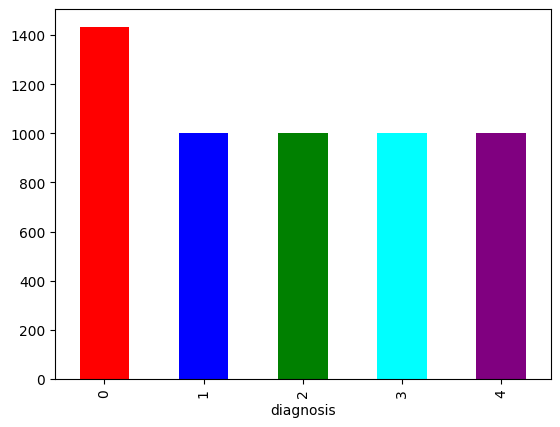

In [21]:
labels_train['diagnosis'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'green', 'cyan', 'purple'])

## Set up transformation

In [22]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    #transforms.CenterCrop(img_size),
    transforms.ToTensor(),               # convert to tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # ImageNet mean
        std=[0.229, 0.224, 0.225]
    )
])

## Define custom Dataset

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None, preload=True):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.preload = preload

        # Map filenames and labels
        self.filenames = self.labels_df['id_code'].values
        self.labels = self.labels_df['diagnosis'].values

        self.images = []  # qui salveremo le immagini pre-caricate

        if self.preload:
            print("Caricamento immagini in RAM...")
            for fname in tqdm(self.filenames, desc="Caricamento immagini", unit="img"):
                img_path = os.path.join(self.img_dir, fname + ".png")
                image = Image.open(img_path).convert("RGB")

                if self.transform:
                    image = self.transform(image)

                self.images.append(image)
            print(f"Caricate {len(self.images)} immagini in memoria.")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if self.preload:
            image = self.images[idx]
        else:
            img_path = os.path.join(self.img_dir, self.filenames[idx] + ".png")
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

        label = self.labels[idx]

        # If label is not numeric, convert to class index
        if isinstance(label, str):
            # Optional: map string labels to integers
            # You can build a mapping outside this class
            raise ValueError("Labels are strings. Convert them to int first.")

        return image, label


In [24]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU
device

device(type='cuda')

In [25]:
num_cuda_devices = torch.cuda.device_count()
print(f"CUDA è disponibile. Numero di dispositivi GPU: {num_cuda_devices}")

    # (Opzionale) Stampa il nome di ciascun dispositivo
for i in range(num_cuda_devices):
    print(f"Dispositivo {i}: {torch.cuda.get_device_name(i)}")

CUDA è disponibile. Numero di dispositivi GPU: 1
Dispositivo 0: NVIDIA GeForce RTX 4060 Laptop GPU


## Create datasets and loaders

In [26]:
if local_runtime==1:
    train_set_preload = True
else:
    train_set_preload = False
    
train_set = CustomImageDataset(augm_train_dir, labels_train, transform=transform, preload=train_set_preload)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = CustomImageDataset(processed_val_dir, labels_val, transform=transform, preload=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_set = CustomImageDataset(processed_test_dir, labels_test, transform=transform, preload=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Caricamento immagini in RAM...


Caricamento immagini: 100%|██████████| 5434/5434 [01:32<00:00, 58.61img/s]

Caricate 5434 immagini in memoria.


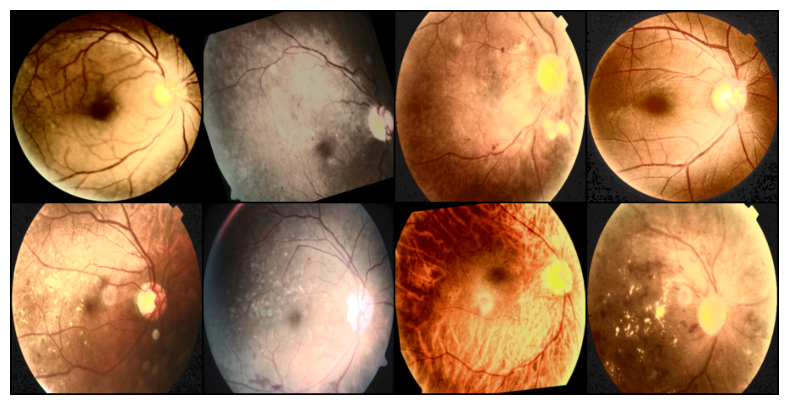

Labels: [0, 2, 2, 0, 2, 4, 1, 3]


In [27]:
# Get one batch from the DataLoader
images, labels = next(iter(train_loader))  # images: [B, 3, 224, 224], labels: [B]

# Denormalize for display (undo ImageNet normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images = images * std + mean  # undo normalization

# Make a grid of images
grid = torchvision.utils.make_grid(images[:8], nrow=4)  # first 8 images, 4 per row

# Convert to numpy for matplotlib (C,H,W -> H,W,C)
grid_np = grid.permute(1, 2, 0).numpy()

# Plot the images
plt.figure(figsize=(10, 5))
plt.imshow(grid_np)
plt.axis('off')
plt.show()

# Print corresponding labels
print("Labels:", labels[:8].tolist())

## Subset Loader

In [28]:
if use_subset_loader == 1:
    num_classes = 5
    samples_per_class = 700

    # Dictionary to hold indices for each class
    class_indices = {c: [] for c in range(num_classes)}

    # Iterate through dataset and collect indices by class
    for idx, row in labels_train.iterrows():
        label = int(row['diagnosis'])
        class_indices[label].append(idx)

    # For each class, randomly sample 200 indices
    subset_indices = []
    for c in range(num_classes):
        chosen = np.random.choice(class_indices[c], samples_per_class, replace=False)
        subset_indices.extend(chosen)

    # Shuffle the final list of subset indices
    np.random.shuffle(subset_indices)

    # Create a subset of the dataset
    subset_dataset = Subset(train_set, subset_indices)

    # Create a new DataLoader for the subset
    subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

In [29]:
from collections import Counter

if use_subset_loader == 1:
    labels_check = []
    for _, label in subset_dataset:
        labels_check.append(int(label))

    print("Class distribution in subset:", Counter(labels_check))

Class distribution in subset: Counter({4: 700, 3: 700, 1: 700, 0: 700, 2: 700})


In [30]:
if use_subset_loader==1:
    loader_selected = subset_loader
else:
    loader_selected = train_loader

## Helper function for model training and evaluation

In [85]:
def build_optimizer(
    name: str,
    params,
    lr: None
) -> optim.Optimizer:
    """
    Crea un optimizer da stringa. Esempi:
    'adam', 'sgd', 'adamw', 'rmsprop', 'adagrad'
    opt_kwargs: qualunque parametro aggiuntivo (es. weight_decay, momentum...)
    """
    name = name.strip().lower()
    if name == "adam":
        if lr is None:
            return optim.Adam(params)
        else:
            return optim.Adam(params, lr=lr)
    if name == "adamw":
        if lr is None:
            return optim.AdamW(params)
        else:
            return optim.AdamW(params, lr=lr)
    if name == "sgd":
        if lr is None:
            return optim.SGD(params)
        else:
            return optim.SGD(params, lr=lr)
    if name == "rmsprop":
        if lr is None:
            return optim.RMSprop(params)
        else:
            return optim.RMSprop(params, lr=lr)
    if name == "adagrad":
        if lr is None:
            return optim.Adagrad(params)
        else:
            return optim.Adagrad(params, lr=lr)
    raise ValueError(f"Optimizer sconosciuto: '{name}'")

def is_focal_loss(
    name: str
) -> nn.Module:
    name = name.strip().lower()
    if name in ("focal", "focallos"):
        return True
    else:
        return False

def build_criterion(
    name: str
) -> nn.Module:
    """
    Crea una loss da stringa. Esempi:
    'crossentropy', 'bcelogits', 'mse', 'nll', 'smoothl1'
    loss_kwargs: parametri extra (es. weight, reduction, label_smoothing...)
    """
    name = name.strip().lower()
    if name in ("crossentropy", "crossentropyloss", "ce"):
        return nn.CrossEntropyLoss()
    if name in ("bcelogits", "bcelosslogits", "bcelogitsloss"):
        return nn.BCEWithLogitsLoss()
    if name in ("mse", "mseloss", "l2"):
        return nn.MSELoss()
    if name in ("nll", "nllloss"):
        return nn.NLLLoss()
    if name in ("smoothl1", "huber"):
        return nn.SmoothL1Loss()
    if is_focal_loss(name):
        return FocalLoss(gamma=2.0)
    raise ValueError(f"Criterion sconosciuto: '{name}'")

def build_scheduler(name: str, optimizer) -> nn.Module:
    name = name.strip().lower()
    if name in ("reducelronplateau"):
        return ReduceLROnPlateau(
            optimizer,
            mode='min',       # because we want to minimize val_loss
            factor=0.3,       # reduce LR by 0.3
            patience=2,       # wait 2 epochs before reducing LR
        )
    else:
        return None

In [32]:
def multiclass_accuracy(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calcola l'accuracy per classificazione multi-classe (es. 5 classi).
    outputs: tensor [N, num_classes]
    targets: tensor [N]
    """
    preds = outputs.argmax(dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / max(1, total)

In [86]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: None,
    optimizer_name: "adam",
    criterion_name: "crossentropy",
    lr: None,
    num_epochs: 5,
    device: None,
    scheduler_name = None,
    verbose: bool = True,
    model_output_softmax = False
) -> Dict[str, List[float]]:
    """
    Esegue training (e opzionalmente validazione) per num_epochs.
    Ritorna uno storico con 'step_losses', 'epoch_losses', 'val_losses'.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = build_criterion(criterion_name)
    optimizer = build_optimizer(optimizer_name, model.parameters(), lr=lr)
    uses_focal_loss = is_focal_loss(criterion_name)
    scheduler = build_scheduler(scheduler_name, optimizer)

    history = {
        "step_losses": [],
        "epoch_losses": [],
        "val_losses": [],
        "epoch_acc": [],
        "val_acc": []
    }


    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            train_iter = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        else:
            train_iter = enumerate(train_loader)

        for _, (images, labels) in train_iter:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if uses_focal_loss and not model_output_softmax:
                loss = criterion(torch.softmax(outputs, dim=-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # --- metriche ---
            acc = multiclass_accuracy(outputs, labels)
            correct_train += acc * labels.size(0)
            total_train += labels.size(0)

            epoch_loss += loss.item()
            history["step_losses"].append(loss.item())

            if verbose:
                if hasattr(train_iter, "set_description"):
                    train_iter.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
                if hasattr(train_iter, "set_postfix"):
                    train_iter.set_postfix(loss=loss.item(), acc=acc)

        avg_epoch_loss = epoch_loss / max(1, len(train_loader))
        epoch_acc = correct_train / max(1, total_train)
        history["epoch_losses"].append(avg_epoch_loss)
        history["epoch_acc"].append(epoch_acc)

        # Validazione (se fornito val_loader)
        if val_loader is not None:
            model.eval()
            val_loss_total = 0.0
            correct_val = 0
            total_val = 0
            n_val_batches = 0
            with torch.no_grad():
                val_iter = tqdm(val_loader, total=len(val_loader), leave=False) if verbose else val_loader
                for X_val, Y_val in val_iter:
                    X_val, Y_val = X_val.to(device), Y_val.to(device)
                    Y_pred_val = model(X_val)

                    if uses_focal_loss:
                        loss_val = criterion(torch.softmax(Y_pred_val, dim=-1), Y_val)
                    else:
                        loss_val = criterion(Y_pred_val, Y_val)

                    val_loss_total += loss_val.item()
                    acc_val = multiclass_accuracy(Y_pred_val, Y_val)
                    correct_val += acc_val * Y_val.size(0)
                    total_val += Y_val.size(0)

                    n_val_batches += 1

            avg_val_loss = val_loss_total / max(1, n_val_batches)
            val_acc = correct_val / max(1, total_val)
            history["val_losses"].append(avg_val_loss)
            history["val_acc"].append(val_acc)
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}, validation loss: {avg_val_loss:.4f} validation acc={val_acc:.4f}")
        else:
            # se non c'è validazione, manteniamo lunghezze allineate
            history["val_losses"].append(float('nan'))
            history["val_acc"].append(float('nan'))
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}")

        # Step dello scheduler (se presente)
        if scheduler is not None:
            # Alcuni scheduler richiedono val_loss (es. ReduceLROnPlateau)
            if hasattr(scheduler, 'step') and scheduler.__class__.__name__.lower().startswith('reducelronplateau'):
                last_val = history["val_losses"][-1]
                # usa train loss se non c'è validazione
                metric = last_val if not (last_val != last_val) else avg_epoch_loss
                scheduler.step(metric)
            else:
                scheduler.step()

    return history, model


In [34]:
def plot_history(history, figsize=(15, 5), save_path=None, show=True):
    """
    Mostra (e opzionalmente salva) tre grafici:
      1. Step Losses (per batch)
      2. Epoch Losses (train e validation)
      3. Epoch Accuracy (train e validation)

    Parametri
    ----------
    history : dict
        Dizionario prodotto da train_model, con chiavi:
            - "step_losses": perdite per batch
            - "epoch_losses": perdite medie di training per epoca
            - "val_losses": perdite medie di validazione per epoca
            - "epoch_acc": accuracy di training per epoca
            - "val_acc": accuracy di validazione per epoca
    figsize : tuple
        Dimensioni della figura (default: (15, 4))
    save_path : str, opzionale
        Se specificato, salva il grafico nel percorso indicato.
    show : bool
        Se True mostra il grafico (default: True)
    title : str
        Titolo generale della figura.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # --- Step losses (batch) ---
    axes[0].plot(history["step_losses"])
    axes[0].set_title("Step Losses")
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")

    # --- Epoch losses (train + val) ---
    axes[1].plot(history["epoch_losses"], label="Training Loss")
    axes[1].plot(history["val_losses"], label="Validation Loss")
    axes[1].set_title("Epoch Losses")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    axes[2].plot(history.get("epoch_acc", []), label="Training Accuracy", marker='o')
    axes[2].plot(history.get("val_acc", []), label="Validation Accuracy", marker='o')
    axes[2].set_title("Epoch Accuracy")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    #axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()

    return fig, axes


In [35]:
def evaluate_model(
    model,
    test_loader,
    average: str = "macro",
    show_confusion: bool = False
):
    """
    Valuta il modello sul test set e restituisce le metriche principali.

    Parametri
    ----------
    model : torch.nn.Module
        Il modello PyTorch da valutare.
    test_loader : DataLoader
        Dataloader del set di test.
    average : str
        Tipo di media per precision/recall/F1 ("macro", "micro", "weighted", "binary").
    show_confusion : bool
        Se True, stampa anche la matrice di confusione.

    Ritorna
    -------
    metrics : dict
        Dizionario con chiavi:
        - "accuracy"
        - "precision"
        - "recall"
        - "f1"
        - "confusion_matrix" (se show_confusion=True)
    """
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Calcolo metriche ---
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average=average, zero_division=0)
    rec = recall_score(all_labels, all_preds, average=average, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=average, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    cm = confusion_matrix(all_labels, all_preds)
    if show_confusion:
        metrics["confusion_matrix"] = cm
        print("\nConfusion Matrix:\n", cm)

    print(f"Test Accuracy: {acc * 100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

    return metrics, cm


In [36]:
def cleanup_torch_env(model_name: None):
    """
    Pulisce in sicurezza l'ambiente PyTorch:
    - Sposta il modello su CPU (se esiste)
    - Elimina l'optimizer (se esiste)
    - Elimina eventuali variabili temporanee note
    - Esegue garbage collection e svuota la cache GPU

    Parametri
    ----------
    model_name : str
        Nome della variabile modello da spostare su CPU.
    optimizer_name : str
        Nome della variabile optimizer da eliminare.
    """
    # --- Sposta modello su CPU ---
    if model_name in globals():
        globals()[model_name] = globals()[model_name].cpu()
    elif model_name in locals():
        locals()[model_name] = locals()[model_name].cpu()

    # --- Cancella variabili temporanee ---
    temp_vars = [
        'outputs', 'loss', 'images', 'labels',
        'Y_pred_val', 'X_val', 'Y_val',
        'sample_preds_labels', 'sample_labels',
        'sample_images', 'sample_preds',
        'all_labels', 'all_preds'
    ]

    for var in temp_vars:
        if var in globals():
            del globals()[var]
        elif var in locals():
            del locals()[var]

    # --- Garbage collector e cache GPU ---
    gc.collect()
    torch.cuda.empty_cache()

## Grid search helpers

In [37]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

def fig_to_base64(fig) -> str:
    """Converte una figura Matplotlib in stringa base64 PNG e chiude la figura."""
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=200, bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return b64

def get_train_size(train_loader) -> int:
    return len(train_loader.dataset)

def run_experiments_to_single_csv(
    model_fn: Callable[[], torch.nn.Module],
    train_loader,
    val_loader,
    test_loader,
    param_grid: Dict[str, List[Any]],
    model_name: str = "model",
    csv_folder = base_path+"/results/",
    num_epochs: int = 5,
    seed: int = 42,
    device: Optional[torch.device] = None,
    model_output_softmax = False
):
    os.makedirs(csv_folder, exist_ok=True)
    """
    Esegue tutte le combinazioni e APPENDE una riga per run a un unico CSV.
    La riga contiene: parametri, dimensioni train set, metriche test, cm (json), plot (base64).
    """
    set_seed(seed)

    keys = list(param_grid.keys())
    combos = list(itertools.product(*(param_grid[k] for k in keys)))
    print(f"Partono {len(combos)} esperimenti...\n")

    # Prepara CSV: scrivi header solo se non esiste
    out_csv_path = csv_folder+model_name+".csv"
    write_header = not os.path.exists(out_csv_path)

    for i, values in enumerate(combos, 1):
        params = {k: v for k, v in zip(keys, values)}
        run_name = f"{model_name}_run_{i:03d}_" + "_".join(f"{k}={v}" for k, v in params.items())
        print(f"[{i}/{len(combos)}] {run_name}")

        # Nuovo modello per ogni run
        model = model_fn()
        train_size = get_train_size(train_loader)

        # Train
        history, model = train_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer_name=params["optimizer_name"],
                criterion_name=params["criterion_name"],
                lr=params["lr"],
                num_epochs=num_epochs,
                device=device,
                scheduler=None,
                model_output_softmax=model_output_softmax
            )

        # History -> plot -> base64 (niente salvataggi su disco)
        plot_history(history, figsize=(15, 5), save_path=csv_folder+run_name+".png", show=False)

        # Valutazione test (metriche + cm)
        metrics, cm = evaluate_model(
                model=model,
                test_loader=test_loader,
                average="macro",
                show_confusion=False
            )

        # Prepara riga per CSV (cm serializzata in JSON, plot come base64)
        row = {
                "run_name": run_name,
                "optimizer_name": params["optimizer_name"],
                "criterion_name": params["criterion_name"],
                "lr": float(params["lr"]),
                "num_epochs": int(num_epochs),
                "train_size": int(train_size),
                "seed": int(seed),
                "device": str(device),
                "test_accuracy": float(metrics.get("accuracy", float("nan"))),
                "test_precision": float(metrics.get("precision", float("nan"))),
                "test_recall": float(metrics.get("recall", float("nan"))),
                "test_f1": float(metrics.get("f1", float("nan"))),
                "confusion_matrix_json": json.dumps(cm.tolist()),
                "graph_image_name": str(run_name+".png")
            }
        
        # Scrivi/append sul CSV
        df = pd.DataFrame([row])
        df.to_csv(out_csv_path, mode="a", header=write_header, index=False)
        write_header = False  # solo la prima volta

        cleanup_torch_env(model)

    print(f"\nTutte le run sono salvate in: {out_csv_path}")


In [38]:
grid = {
        #"optimizer_name": ["sgd", "adam", "adamw"],
        #"lr": [1e-4, 1e-3, 5e-3],
        #"criterion_name": ["crossentropy", "focal"],
        "optimizer_name": ["adam"],
        "lr": [1e-3],
        "criterion_name": ["crossentropy"]
    }

## Define the first model (simple one), train and evaluate it

In [60]:
# define the class

class FMCNN(nn.Module):
    def __init__(self):
        super(FMCNN, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*int(img_size/4)*int(img_size/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
model = FMCNN()
print(model)
summary(model, input_size=(1, 3, 224, 224))

In [ ]:
history, model = train_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    num_epochs = 5,
    device = device,
    lr=None,
    scheduler=None
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion

print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model")

Partono 1 esperimenti...

[1/1] FMCNN_run_001_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/10


Epoch 1 training loss: 2.3156 train acc=0.3977, validation loss: 0.9527 validation acc=0.6311
Epoch 2/10


Epoch 2 training loss: 1.1478 train acc=0.5211, validation loss: 0.8277 validation acc=0.7131
Epoch 3/10


Epoch 3 training loss: 1.0739 train acc=0.5569, validation loss: 0.8275 validation acc=0.6776
Epoch 4/10


Epoch 4 training loss: 0.9956 train acc=0.5986, validation loss: 0.8035 validation acc=0.6995
Epoch 5/10


Epoch 5 training loss: 0.9189 train acc=0.6211, validation loss: 0.7752 validation acc=0.7077
Epoch 6/10


Epoch 6 training loss: 0.8004 train acc=0.6943, validation loss: 0.7784 validation acc=0.7268
Epoch 7/10


Epoch 7 training loss: 0.6915 train acc=0.7369, validation loss: 0.8658 validation acc=0.6995
Epoch 8/10


Epoch 8 training loss: 0.5890 train acc=0.7734, validation loss: 1.0169 validation acc=0.6393
Epoch 9/10


Epoch 9 training loss: 0.4819 train acc=0.8329, validation loss: 1.0287 validation acc=0.6995
Epoch 10/10


Epoch 10 training loss: 0.4194 train acc=0.8454, validation loss: 1.1315 validation acc=0.6940
Test Accuracy: 71.04% | Precision: 0.466 | Recall: 0.481 | F1: 0.463

Tutte le run sono salvate in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset//results/FMCNN.csv


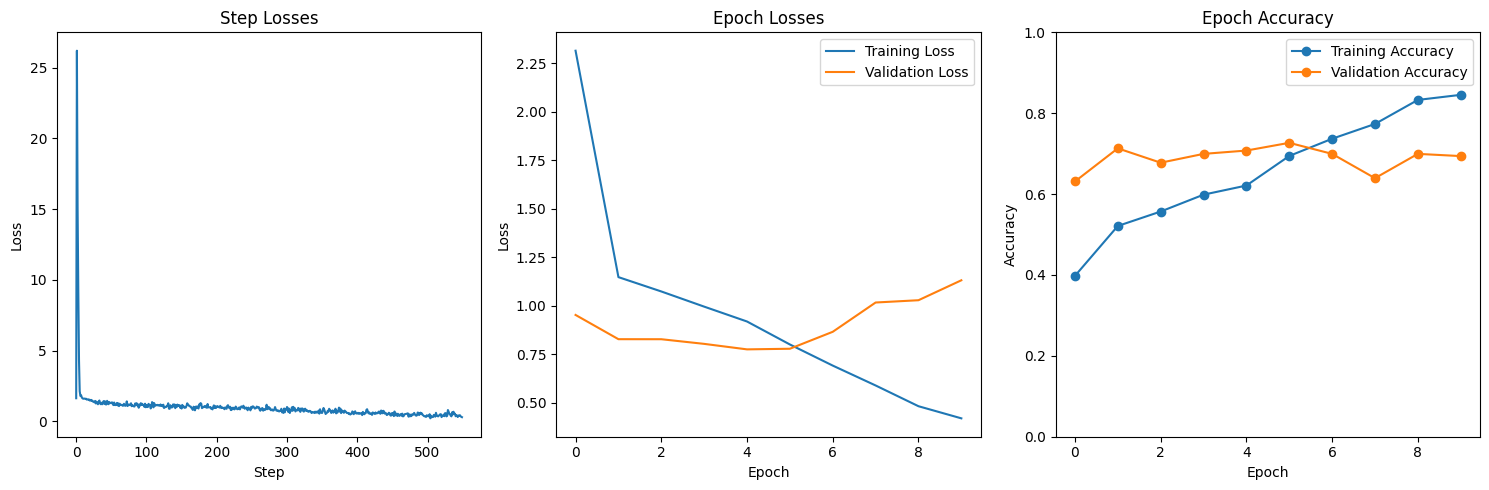

In [62]:
def model_fn():
    return FMCNN()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="FMCNN",
        csv_folder = base_path+"/results/",
        num_epochs=10,
        device=device
    )

### Test with a subset of the dataset

In [ ]:
history, model = train_model(
    model = model,
    train_loader = subset_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    num_epochs = 10,
    device = device
)

In [ ]:
plot_history(history = history)

In [63]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

NameError: name 'model' is not defined

In [ ]:
cleanup_torch_env("model")

## Test with another model


In [ ]:
model_vgg16 = models.vgg16(weights=None, num_classes=5)

print(model_vgg16)

In [ ]:
summary(model_vgg16, input_size=(32, 3, img_size, img_size))

In [ ]:
history, model_vgg16 = train_model(
    model = model_vgg16,
    train_loader = loader_selected,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    lr=1e-4,
    num_epochs = 5,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
torch.save(model_vgg16, base_path + "model_vgg.pth")

In [ ]:
# Evaluate the model
model2 = torch.load(base_path+"model_vgg.pth", weights_only=False)

metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow


In [ ]:
cleanup_torch_env("model2")
cleanup_torch_env("model_vgg16")

Partono 18 esperimenti...

[1/18] vgg16_run_001_optimizer_name=sgd_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6115 train acc=0.2145, validation loss: 1.6210 validation acc=0.1721
Epoch 2/30


Epoch 2 training loss: 1.6121 train acc=0.2042, validation loss: 1.6155 validation acc=0.1721
Epoch 3/30


Epoch 3 training loss: 1.6140 train acc=0.1971, validation loss: 1.6107 validation acc=0.1721
Epoch 4/30


Epoch 4 training loss: 1.6122 train acc=0.2010, validation loss: 1.6063 validation acc=0.2486
Epoch 5/30


Epoch 5 training loss: 1.6109 train acc=0.2059, validation loss: 1.6010 validation acc=0.4863
Epoch 6/30


Epoch 6 training loss: 1.6092 train acc=0.2085, validation loss: 1.5973 validation acc=0.5219
Epoch 7/30


Epoch 7 training loss: 1.6075 train acc=0.2146, validation loss: 1.5933 validation acc=0.4973
Epoch 8/30


Epoch 8 training loss: 1.6086 train acc=0.2084, validation loss: 1.5909 validation acc=0.4672
Epoch 9/30


Epoch 9 training loss: 1.6072 train acc=0.2102, validation loss: 1.5877 validation acc=0.4508
Epoch 10/30


Epoch 10 training loss: 1.6064 train acc=0.2226, validation loss: 1.5846 validation acc=0.4590
Epoch 11/30


Epoch 11 training loss: 1.6067 train acc=0.2204, validation loss: 1.5828 validation acc=0.4672
Epoch 12/30


Epoch 12 training loss: 1.6061 train acc=0.2177, validation loss: 1.5807 validation acc=0.4645
Epoch 13/30


Epoch 13 training loss: 1.6057 train acc=0.2287, validation loss: 1.5782 validation acc=0.4672
Epoch 14/30


Epoch 14 training loss: 1.6063 train acc=0.2255, validation loss: 1.5758 validation acc=0.4672
Epoch 15/30


Epoch 15 training loss: 1.6056 train acc=0.2251, validation loss: 1.5743 validation acc=0.4699
Epoch 16/30


Epoch 16 training loss: 1.6036 train acc=0.2397, validation loss: 1.5720 validation acc=0.4699
Epoch 17/30


Epoch 17 training loss: 1.6030 train acc=0.2354, validation loss: 1.5695 validation acc=0.4699
Epoch 18/30


Epoch 18 training loss: 1.6027 train acc=0.2466, validation loss: 1.5683 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 1.6026 train acc=0.2385, validation loss: 1.5660 validation acc=0.4699
Epoch 20/30


Epoch 20 training loss: 1.6012 train acc=0.2434, validation loss: 1.5628 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 1.6032 train acc=0.2396, validation loss: 1.5621 validation acc=0.4672
Epoch 22/30


Epoch 22 training loss: 1.6004 train acc=0.2471, validation loss: 1.5597 validation acc=0.4699
Epoch 23/30


Epoch 23 training loss: 1.6011 train acc=0.2457, validation loss: 1.5576 validation acc=0.4699
Epoch 24/30


Epoch 24 training loss: 1.5995 train acc=0.2463, validation loss: 1.5550 validation acc=0.4699
Epoch 25/30


Epoch 25 training loss: 1.6019 train acc=0.2425, validation loss: 1.5540 validation acc=0.4672
Epoch 26/30


Epoch 26 training loss: 1.5991 train acc=0.2522, validation loss: 1.5518 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 1.5990 train acc=0.2452, validation loss: 1.5491 validation acc=0.4699
Epoch 28/30


Epoch 28 training loss: 1.5966 train acc=0.2558, validation loss: 1.5469 validation acc=0.4699
Epoch 29/30


Epoch 29 training loss: 1.5973 train acc=0.2590, validation loss: 1.5456 validation acc=0.4672
Epoch 30/30


Epoch 30 training loss: 1.5970 train acc=0.2554, validation loss: 1.5442 validation acc=0.4672
Test Accuracy: 53.83% | Precision: 0.109 | Recall: 0.198 | F1: 0.140
[2/18] vgg16_run_002_optimizer_name=sgd_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0331 train acc=0.2028, validation loss: 1.0337 validation acc=0.0738
Epoch 2/30


Epoch 2 training loss: 1.0315 train acc=0.2059, validation loss: 1.0310 validation acc=0.0847
Epoch 3/30


Epoch 3 training loss: 1.0297 train acc=0.2100, validation loss: 1.0295 validation acc=0.1366
Epoch 4/30


Epoch 4 training loss: 1.0306 train acc=0.2092, validation loss: 1.0269 validation acc=0.3033
Epoch 5/30


Epoch 5 training loss: 1.0289 train acc=0.2163, validation loss: 1.0259 validation acc=0.3579
Epoch 6/30


Epoch 6 training loss: 1.0283 train acc=0.2181, validation loss: 1.0240 validation acc=0.3934
Epoch 7/30


Epoch 7 training loss: 1.0294 train acc=0.2139, validation loss: 1.0211 validation acc=0.4290
Epoch 8/30


Epoch 8 training loss: 1.0263 train acc=0.2226, validation loss: 1.0195 validation acc=0.4508
Epoch 9/30


Epoch 9 training loss: 1.0279 train acc=0.2201, validation loss: 1.0183 validation acc=0.4891
Epoch 10/30


Epoch 10 training loss: 1.0272 train acc=0.2177, validation loss: 1.0163 validation acc=0.4945
Epoch 11/30


Epoch 11 training loss: 1.0258 train acc=0.2307, validation loss: 1.0150 validation acc=0.5246
Epoch 12/30


Epoch 12 training loss: 1.0258 train acc=0.2325, validation loss: 1.0146 validation acc=0.5055
Epoch 13/30


Epoch 13 training loss: 1.0261 train acc=0.2241, validation loss: 1.0141 validation acc=0.4836
Epoch 14/30


Epoch 14 training loss: 1.0257 train acc=0.2191, validation loss: 1.0138 validation acc=0.4781
Epoch 15/30


Epoch 15 training loss: 1.0264 train acc=0.2241, validation loss: 1.0135 validation acc=0.4727
Epoch 16/30


Epoch 16 training loss: 1.0230 train acc=0.2363, validation loss: 1.0112 validation acc=0.5191
Epoch 17/30


Epoch 17 training loss: 1.0241 train acc=0.2343, validation loss: 1.0094 validation acc=0.5164
Epoch 18/30


Epoch 18 training loss: 1.0230 train acc=0.2361, validation loss: 1.0083 validation acc=0.5464
Epoch 19/30


Epoch 19 training loss: 1.0229 train acc=0.2413, validation loss: 1.0078 validation acc=0.5492
Epoch 20/30


Epoch 20 training loss: 1.0235 train acc=0.2410, validation loss: 1.0077 validation acc=0.5464
Epoch 21/30


Epoch 21 training loss: 1.0236 train acc=0.2411, validation loss: 1.0068 validation acc=0.5464
Epoch 22/30


Epoch 22 training loss: 1.0222 train acc=0.2418, validation loss: 1.0042 validation acc=0.5601
Epoch 23/30


Epoch 23 training loss: 1.0212 train acc=0.2449, validation loss: 1.0031 validation acc=0.5601
Epoch 24/30


Epoch 24 training loss: 1.0225 train acc=0.2399, validation loss: 1.0012 validation acc=0.5628
Epoch 25/30


Epoch 25 training loss: 1.0212 train acc=0.2538, validation loss: 0.9997 validation acc=0.5601
Epoch 26/30


Epoch 26 training loss: 1.0202 train acc=0.2441, validation loss: 0.9984 validation acc=0.5574
Epoch 27/30


Epoch 27 training loss: 1.0192 train acc=0.2628, validation loss: 0.9980 validation acc=0.5601
Epoch 28/30


Epoch 28 training loss: 1.0179 train acc=0.2612, validation loss: 0.9956 validation acc=0.5738
Epoch 29/30


Epoch 29 training loss: 1.0192 train acc=0.2538, validation loss: 0.9955 validation acc=0.5683
Epoch 30/30


Epoch 30 training loss: 1.0184 train acc=0.2632, validation loss: 0.9929 validation acc=0.5820
Test Accuracy: 63.66% | Precision: 0.262 | Recall: 0.315 | F1: 0.285
[3/18] vgg16_run_003_optimizer_name=sgd_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6125 train acc=0.2081, validation loss: 1.5825 validation acc=0.5000
Epoch 2/30


Epoch 2 training loss: 1.6057 train acc=0.2280, validation loss: 1.5675 validation acc=0.5410
Epoch 3/30


Epoch 3 training loss: 1.5991 train acc=0.2469, validation loss: 1.5680 validation acc=0.4454
Epoch 4/30


Epoch 4 training loss: 1.5926 train acc=0.2714, validation loss: 1.5671 validation acc=0.4645
Epoch 5/30


Epoch 5 training loss: 1.5841 train acc=0.2856, validation loss: 1.5166 validation acc=0.4617
Epoch 6/30


Epoch 6 training loss: 1.5659 train acc=0.3046, validation loss: 1.4670 validation acc=0.5246
Epoch 7/30


Epoch 7 training loss: 1.5473 train acc=0.3191, validation loss: 1.4358 validation acc=0.4399
Epoch 8/30


Epoch 8 training loss: 1.5088 train acc=0.3411, validation loss: 1.2173 validation acc=0.5683
Epoch 9/30


Epoch 9 training loss: 1.4685 train acc=0.3591, validation loss: 1.2542 validation acc=0.5929
Epoch 10/30


Epoch 10 training loss: 1.4261 train acc=0.3745, validation loss: 1.1418 validation acc=0.5519
Epoch 11/30


Epoch 11 training loss: 1.4078 train acc=0.3717, validation loss: 1.4512 validation acc=0.3634
Epoch 12/30


Epoch 12 training loss: 1.3700 train acc=0.3971, validation loss: 1.2936 validation acc=0.4071
Epoch 13/30


Epoch 13 training loss: 1.3488 train acc=0.3939, validation loss: 1.7304 validation acc=0.2022
Epoch 14/30


Epoch 14 training loss: 1.3289 train acc=0.4060, validation loss: 1.0074 validation acc=0.6448
Epoch 15/30


Epoch 15 training loss: 1.3174 train acc=0.4079, validation loss: 1.1432 validation acc=0.4617
Epoch 16/30


Epoch 16 training loss: 1.3028 train acc=0.4126, validation loss: 1.1704 validation acc=0.4918
Epoch 17/30


Epoch 17 training loss: 1.2883 train acc=0.4259, validation loss: 0.9121 validation acc=0.6639
Epoch 18/30


Epoch 18 training loss: 1.2723 train acc=0.4245, validation loss: 0.9756 validation acc=0.6421
Epoch 19/30


Epoch 19 training loss: 1.2647 train acc=0.4344, validation loss: 0.9703 validation acc=0.6311
Epoch 20/30


Epoch 20 training loss: 1.2514 train acc=0.4430, validation loss: 1.4531 validation acc=0.3333
Epoch 21/30


Epoch 21 training loss: 1.2399 train acc=0.4485, validation loss: 1.0824 validation acc=0.4836
Epoch 22/30


Epoch 22 training loss: 1.2492 train acc=0.4495, validation loss: 1.0726 validation acc=0.5191
Epoch 23/30


Epoch 23 training loss: 1.2421 train acc=0.4425, validation loss: 1.0971 validation acc=0.4945
Epoch 24/30


Epoch 24 training loss: 1.2150 train acc=0.4594, validation loss: 0.8656 validation acc=0.6557
Epoch 25/30


Epoch 25 training loss: 1.2118 train acc=0.4596, validation loss: 1.4388 validation acc=0.3716
Epoch 26/30


Epoch 26 training loss: 1.2122 train acc=0.4566, validation loss: 1.1300 validation acc=0.4672
Epoch 27/30


Epoch 27 training loss: 1.2107 train acc=0.4640, validation loss: 1.1644 validation acc=0.5574
Epoch 28/30


Epoch 28 training loss: 1.2033 train acc=0.4573, validation loss: 2.1901 validation acc=0.0984
Epoch 29/30


Epoch 29 training loss: 1.2098 train acc=0.4669, validation loss: 2.2087 validation acc=0.1230
Epoch 30/30


Epoch 30 training loss: 1.2125 train acc=0.4646, validation loss: 0.9323 validation acc=0.6175
Test Accuracy: 69.95% | Precision: 0.535 | Recall: 0.383 | F1: 0.362
[4/18] vgg16_run_004_optimizer_name=sgd_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0307 train acc=0.2039, validation loss: 1.0244 validation acc=0.1148
Epoch 2/30


Epoch 2 training loss: 1.0266 train acc=0.2212, validation loss: 1.0121 validation acc=0.4399
Epoch 3/30


Epoch 3 training loss: 1.0220 train acc=0.2448, validation loss: 0.9903 validation acc=0.5902
Epoch 4/30


Epoch 4 training loss: 1.0162 train acc=0.2662, validation loss: 0.9731 validation acc=0.6284
Epoch 5/30


Epoch 5 training loss: 1.0062 train acc=0.2905, validation loss: 0.9554 validation acc=0.5738
Epoch 6/30


Epoch 6 training loss: 0.9976 train acc=0.3113, validation loss: 0.9381 validation acc=0.5492
Epoch 7/30


Epoch 7 training loss: 0.9805 train acc=0.3346, validation loss: 0.9354 validation acc=0.4317
Epoch 8/30


Epoch 8 training loss: 0.9481 train acc=0.3498, validation loss: 0.8734 validation acc=0.4863
Epoch 9/30


Epoch 9 training loss: 0.8977 train acc=0.3653, validation loss: 0.6864 validation acc=0.5109
Epoch 10/30


Epoch 10 training loss: 0.8444 train acc=0.3863, validation loss: 0.6398 validation acc=0.6093
Epoch 11/30


Epoch 11 training loss: 0.8066 train acc=0.4091, validation loss: 0.5639 validation acc=0.6475
Epoch 12/30


Epoch 12 training loss: 0.7900 train acc=0.4040, validation loss: 0.6149 validation acc=0.5082
Epoch 13/30


Epoch 13 training loss: 0.7755 train acc=0.4071, validation loss: 0.6226 validation acc=0.5000
Epoch 14/30


Epoch 14 training loss: 0.7529 train acc=0.4174, validation loss: 0.6168 validation acc=0.5328
Epoch 15/30


Epoch 15 training loss: 0.7427 train acc=0.4247, validation loss: 0.5610 validation acc=0.5929
Epoch 16/30


Epoch 16 training loss: 0.7400 train acc=0.4259, validation loss: 0.6460 validation acc=0.4973
Epoch 17/30


Epoch 17 training loss: 0.7292 train acc=0.4319, validation loss: 0.5030 validation acc=0.6557
Epoch 18/30


Epoch 18 training loss: 0.7354 train acc=0.4298, validation loss: 0.6470 validation acc=0.5628
Epoch 19/30


Epoch 19 training loss: 0.7295 train acc=0.4420, validation loss: 0.5033 validation acc=0.6530
Epoch 20/30


Epoch 20 training loss: 0.7205 train acc=0.4379, validation loss: 0.6401 validation acc=0.4563
Epoch 21/30


Epoch 21 training loss: 0.7145 train acc=0.4517, validation loss: 0.5299 validation acc=0.6120
Epoch 22/30


Epoch 22 training loss: 0.7105 train acc=0.4522, validation loss: 0.5814 validation acc=0.6311
Epoch 23/30


Epoch 23 training loss: 0.7201 train acc=0.4453, validation loss: 2.7070 validation acc=0.1175
Epoch 24/30


Epoch 24 training loss: 0.7156 train acc=0.4536, validation loss: 0.5419 validation acc=0.6093
Epoch 25/30


Epoch 25 training loss: 0.6994 train acc=0.4593, validation loss: 0.4880 validation acc=0.6639
Epoch 26/30


Epoch 26 training loss: 0.7032 train acc=0.4614, validation loss: 0.5736 validation acc=0.6284
Epoch 27/30


Epoch 27 training loss: 0.7042 train acc=0.4563, validation loss: 0.5069 validation acc=0.6557
Epoch 28/30


Epoch 28 training loss: 0.6887 train acc=0.4616, validation loss: 0.4889 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.7022 train acc=0.4646, validation loss: 2.8460 validation acc=0.1066
Epoch 30/30


Epoch 30 training loss: 0.7029 train acc=0.4568, validation loss: 0.5229 validation acc=0.6120
Test Accuracy: 68.58% | Precision: 0.453 | Recall: 0.416 | F1: 0.367
[5/18] vgg16_run_005_optimizer_name=sgd_lr=0.005_criterion_name=crossentropy
Epoch 1/30


KeyboardInterrupt: 

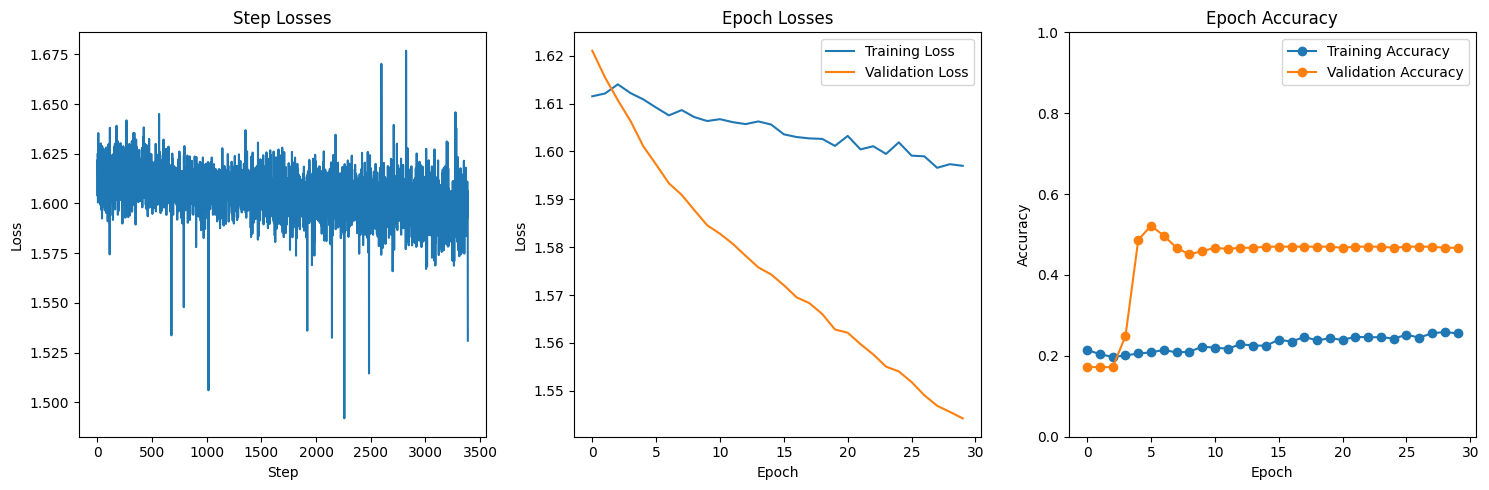

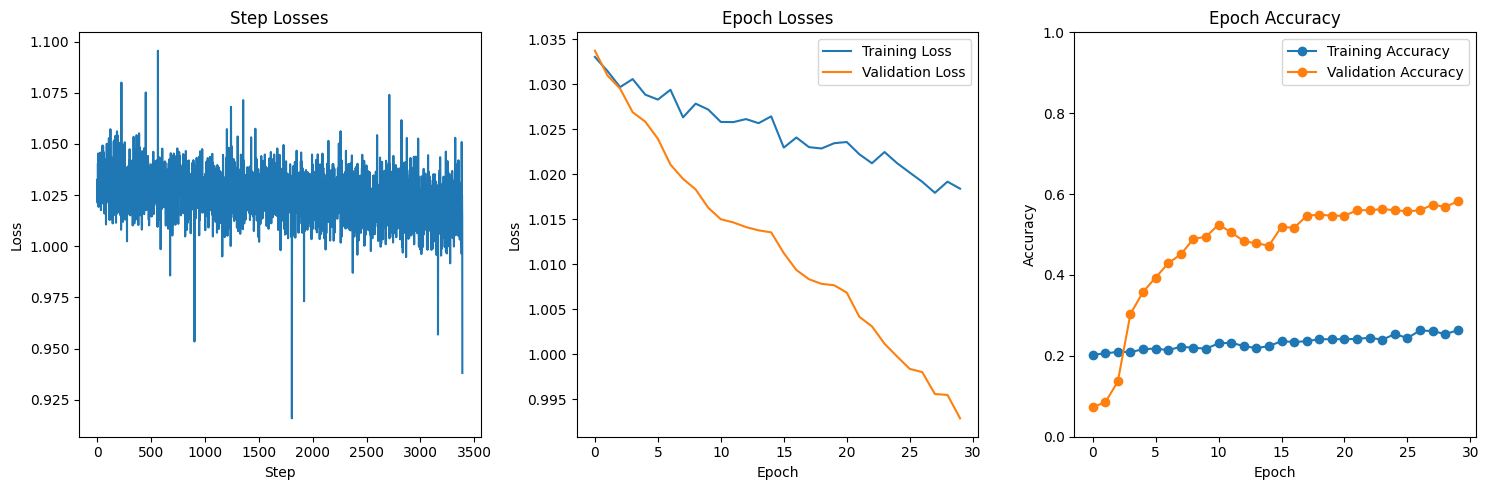

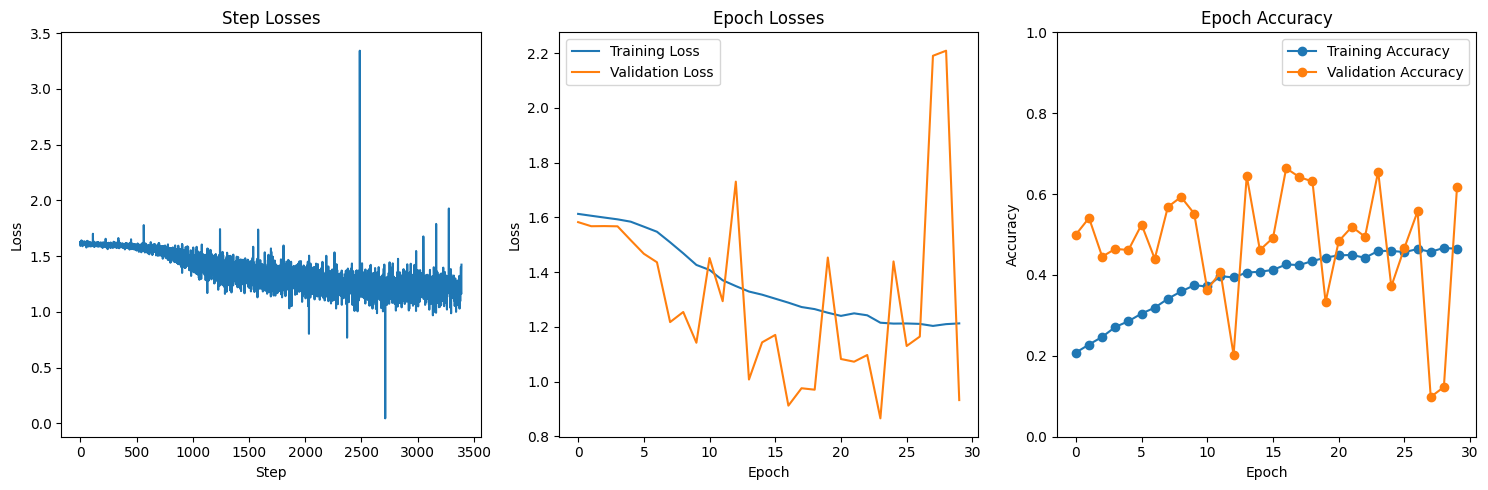

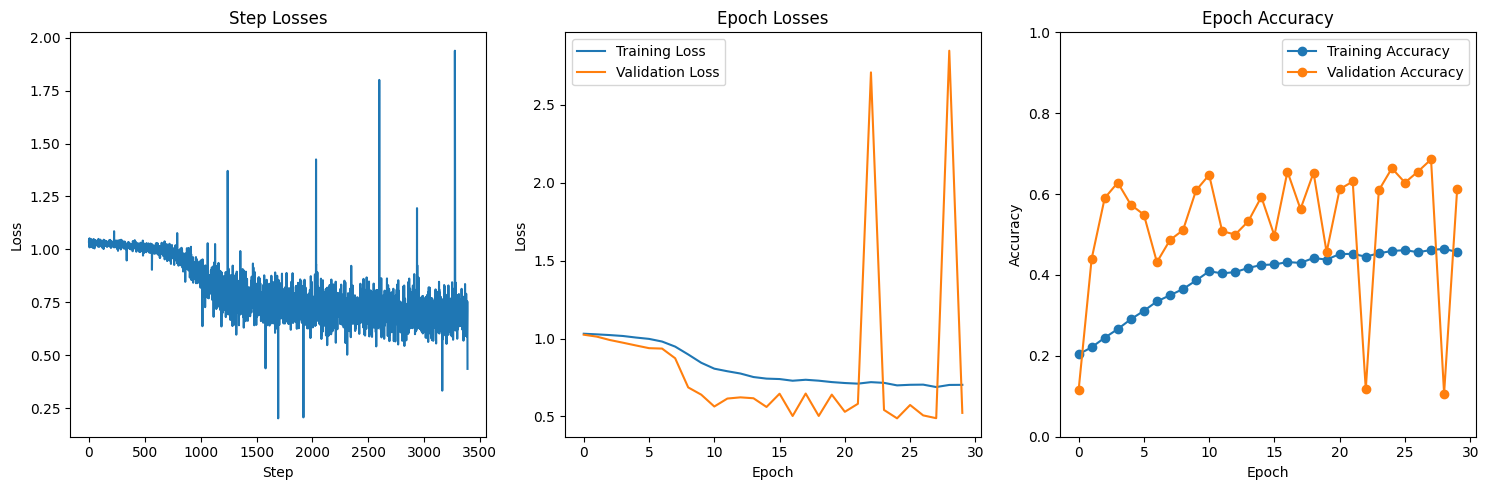

In [ ]:
def model_fn():
    return models.vgg16(weights=None, num_classes=5)

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="vgg16",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

## RSG-Net

In [87]:
class RSGNet(nn.Module):
    def __init__(self):
        super(RSGNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*20*20, out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=5)
        self.gap = nn.AdaptiveMaxPool2d(20)


    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.pool(x)
        x = self.gap(x)
        x = x.view(-1, 128*20*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x

Try a slightly different version, to try and overcome overfitting:
- Early Stopping
- LR scheduling: ReduceLROnPlateau

In [ ]:
class RSGNet(nn.Module):
    def __init__(self):
        super(RSGNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*20*20, out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=5)
        self.gap = nn.AdaptiveMaxPool2d(20)


    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.pool(x)
        x = self.gap(x)
        x = x.view(-1, 128*20*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x

In [98]:
model_rsg = RSGNet()
print(model_rsg)
summary(model_rsg, input_size=(batch_size, 3, img_size, img_size))

RSGNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=51200, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (gap): AdaptiveMaxPool2d(output_size=20)
)


Layer (type:depth-idx)                   Output Shape              Param #
RSGNet                                   [64, 5]                   --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─Conv2d: 1-2                            [64, 32, 224, 224]        9,248
├─MaxPool2d: 1-3                         [64, 32, 112, 112]        --
├─Conv2d: 1-4                            [64, 64, 112, 112]        18,496
├─Conv2d: 1-5                            [64, 128, 112, 112]       73,856
├─AdaptiveMaxPool2d: 1-6                 [64, 128, 20, 20]         --
├─Linear: 1-7                            [64, 128]                 6,553,728
├─BatchNorm1d: 1-8                       [64, 128]                 256
├─Dropout: 1-9                           [64, 128]                 --
├─Linear: 1-10                           [64, 5]                   645
Total params: 6,657,125
Trainable params: 6,657,125
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 107.14
Input size (MB):

In [99]:
history, model_rsg = train_model(
    model = model_rsg,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "sgd",
    lr=0.01,
    num_epochs = 20,
    device = device,
    scheduler_name = "reducelronplateau"
)

Epoch 1/20


Epoch 1 training loss: 1.1978 train acc=0.5011, validation loss: 1.0674 validation acc=0.6230
Epoch 2/20


Epoch 2 training loss: 1.0571 train acc=0.5690, validation loss: 0.9976 validation acc=0.6803
Epoch 3/20


Epoch 3 training loss: 0.9877 train acc=0.6047, validation loss: 0.9609 validation acc=0.6448
Epoch 4/20


Epoch 4 training loss: 0.9340 train acc=0.6294, validation loss: 0.8713 validation acc=0.6557
Epoch 5/20


Epoch 5 training loss: 0.8666 train acc=0.6708, validation loss: 0.7888 validation acc=0.7213
Epoch 6/20


Epoch 6 training loss: 0.7928 train acc=0.7070, validation loss: 1.3786 validation acc=0.4044
Epoch 7/20


Epoch 7 training loss: 0.7304 train acc=0.7337, validation loss: 0.8196 validation acc=0.7104
Epoch 8/20


Epoch 8 training loss: 0.6805 train acc=0.7604, validation loss: 0.8926 validation acc=0.7049
Epoch 9/20


Epoch 9 training loss: 0.5212 train acc=0.8585, validation loss: 0.6983 validation acc=0.7459
Epoch 10/20


Epoch 10 training loss: 0.4488 train acc=0.8914, validation loss: 0.7282 validation acc=0.7158
Epoch 11/20


Epoch 11 training loss: 0.3971 train acc=0.9085, validation loss: 0.7969 validation acc=0.6940
Epoch 12/20


Epoch 12 training loss: 0.3537 train acc=0.9225, validation loss: 0.7437 validation acc=0.7486
Epoch 13/20


Epoch 13 training loss: 0.2938 train acc=0.9531, validation loss: 0.7133 validation acc=0.7459
Epoch 14/20


Epoch 14 training loss: 0.2699 train acc=0.9610, validation loss: 0.7096 validation acc=0.7486
Epoch 15/20


Epoch 15 training loss: 0.2588 train acc=0.9639, validation loss: 0.7245 validation acc=0.7514
Epoch 16/20


Epoch 16 training loss: 0.2372 train acc=0.9722, validation loss: 0.7169 validation acc=0.7404
Epoch 17/20


Epoch 17 training loss: 0.2427 train acc=0.9678, validation loss: 0.7167 validation acc=0.7377
Epoch 18/20


Epoch 18 training loss: 0.2375 train acc=0.9704, validation loss: 0.7169 validation acc=0.7377
Epoch 19/20


Epoch 19 training loss: 0.2290 train acc=0.9766, validation loss: 0.7100 validation acc=0.7350
Epoch 20/20


Epoch 20 training loss: 0.2319 train acc=0.9739, validation loss: 0.7131 validation acc=0.7322


In [96]:
history, model_rsg = train_model(
    model = model_rsg,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "sgd",
    lr=0.001,
    num_epochs = 20,
    device = device,
    scheduler = None
)

TypeError: train_model() got an unexpected keyword argument 'scheduler'

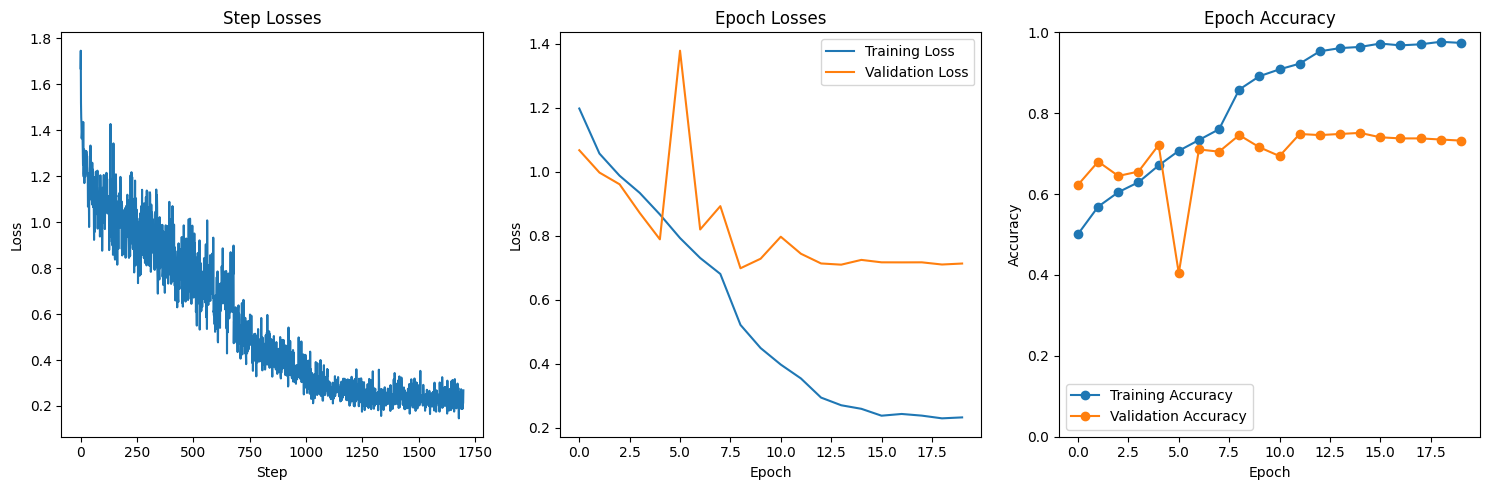

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Step Losses'}, xlabel='Step', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Losses'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

In [100]:
plot_history(history = history)


Confusion Matrix:
 [[193   2   4   0   0]
 [  4  17   7   1   1]
 [  4  17  58   6   2]
 [  1   1   8   5   2]
 [  1   6  10   5  11]]
Test Accuracy: 77.60% | Precision: 0.599 | Recall: 0.566 | F1: 0.567


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Predicted labels: [0 2 4 0 0 0 4 2 1 2 0 0 2 0 2 0 0 0 0 2 0 0 2 3 2 0 0 0 0 2 2 0 2 2 2 0 2
 2 0 3 0 0 1 2 0 2 1 3 1 0 4 0 2 2 2 0 1 0 0 0 0 3 0 2]
True labels: [0 2 4 0 0 0 3 2 1 1 0 0 2 0 2 0 0 0 0 4 0 0 2 2 2 0 0 0 0 0 2 0 2 2 2 0 4
 2 0 3 0 0 2 2 0 4 2 2 2 0 4 0 2 2 2 0 3 0 0 0 2 1 0 3]


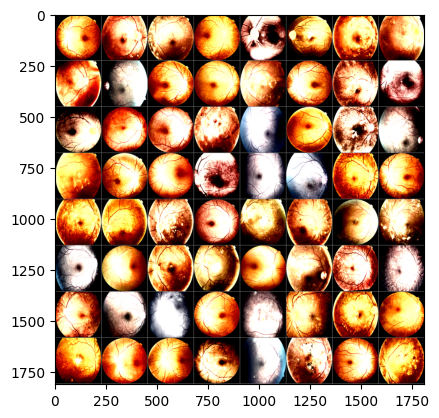

In [101]:
metrics, cm = evaluate_model(
    model_rsg,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_rsg(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [97]:
cleanup_torch_env("model_rsg")

Partono 1 esperimenti...

[1/1] RSGNet_run_001_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.2704 train acc=0.4531, validation loss: 0.8830 validation acc=0.6448
Epoch 2/30


Epoch 2 training loss: 1.1406 train acc=0.5123, validation loss: 0.8677 validation acc=0.6721
Epoch 3/30


Epoch 3 training loss: 1.0905 train acc=0.5351, validation loss: 0.8359 validation acc=0.6995
Epoch 4/30


Epoch 4 training loss: 1.0690 train acc=0.5466, validation loss: 0.8636 validation acc=0.6940
Epoch 5/30


Epoch 5 training loss: 1.0981 train acc=0.5311, validation loss: 0.8818 validation acc=0.6311
Epoch 6/30


Epoch 6 training loss: 1.0792 train acc=0.5429, validation loss: 0.9523 validation acc=0.6612
Epoch 7/30


Epoch 7 training loss: 1.0268 train acc=0.5760, validation loss: 0.8583 validation acc=0.7295
Epoch 8/30


Epoch 8 training loss: 0.9705 train acc=0.6026, validation loss: 0.7903 validation acc=0.7104
Epoch 9/30


Epoch 9 training loss: 0.8998 train acc=0.6500, validation loss: 0.8191 validation acc=0.7049
Epoch 10/30


Epoch 10 training loss: 0.8113 train acc=0.6951, validation loss: 0.8126 validation acc=0.7104
Epoch 11/30


Epoch 11 training loss: 0.6890 train acc=0.7480, validation loss: 0.8649 validation acc=0.6831
Epoch 12/30


Epoch 12 training loss: 0.5434 train acc=0.8094, validation loss: 0.8624 validation acc=0.6858
Epoch 13/30


Epoch 13 training loss: 0.3923 train acc=0.8743, validation loss: 0.9565 validation acc=0.6557
Epoch 14/30


Epoch 14 training loss: 0.2582 train acc=0.9277, validation loss: 1.0472 validation acc=0.6339
Epoch 15/30


Epoch 15 training loss: 0.1823 train acc=0.9594, validation loss: 1.0921 validation acc=0.6749
Epoch 16/30


Epoch 16 training loss: 0.1176 train acc=0.9766, validation loss: 1.0108 validation acc=0.7131
Epoch 17/30


Epoch 17 training loss: 0.0870 train acc=0.9834, validation loss: 1.0920 validation acc=0.6858
Epoch 18/30


Epoch 18 training loss: 0.0607 train acc=0.9914, validation loss: 1.1329 validation acc=0.6885
Epoch 19/30


Epoch 19 training loss: 0.0560 train acc=0.9909, validation loss: 1.3182 validation acc=0.6557
Epoch 20/30


Epoch 20 training loss: 0.0505 train acc=0.9920, validation loss: 1.2071 validation acc=0.6749
Epoch 21/30


Epoch 21 training loss: 0.0454 train acc=0.9920, validation loss: 1.1936 validation acc=0.6776
Epoch 22/30


Epoch 22 training loss: 0.0436 train acc=0.9923, validation loss: 1.3328 validation acc=0.6749
Epoch 23/30


Epoch 23 training loss: 0.0508 train acc=0.9931, validation loss: 1.2047 validation acc=0.6803
Epoch 24/30


Epoch 24 training loss: 0.0380 train acc=0.9934, validation loss: 1.1233 validation acc=0.6967
Epoch 25/30


Epoch 25 training loss: 0.0412 train acc=0.9934, validation loss: 1.2349 validation acc=0.7131
Epoch 26/30


Epoch 26 training loss: 0.0332 train acc=0.9946, validation loss: 1.6421 validation acc=0.6148
Epoch 27/30


Epoch 27 training loss: 0.0367 train acc=0.9929, validation loss: 1.1541 validation acc=0.7104
Epoch 28/30


Epoch 28 training loss: 0.0315 train acc=0.9937, validation loss: 1.5279 validation acc=0.7022
Epoch 29/30


Epoch 29 training loss: 0.0295 train acc=0.9946, validation loss: 1.1593 validation acc=0.7077
Epoch 30/30


Epoch 30 training loss: 0.0301 train acc=0.9949, validation loss: 1.3526 validation acc=0.7077
Test Accuracy: 72.95% | Precision: 0.477 | Recall: 0.455 | F1: 0.439

Tutte le run sono salvate in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset//results/RSGNet.csv


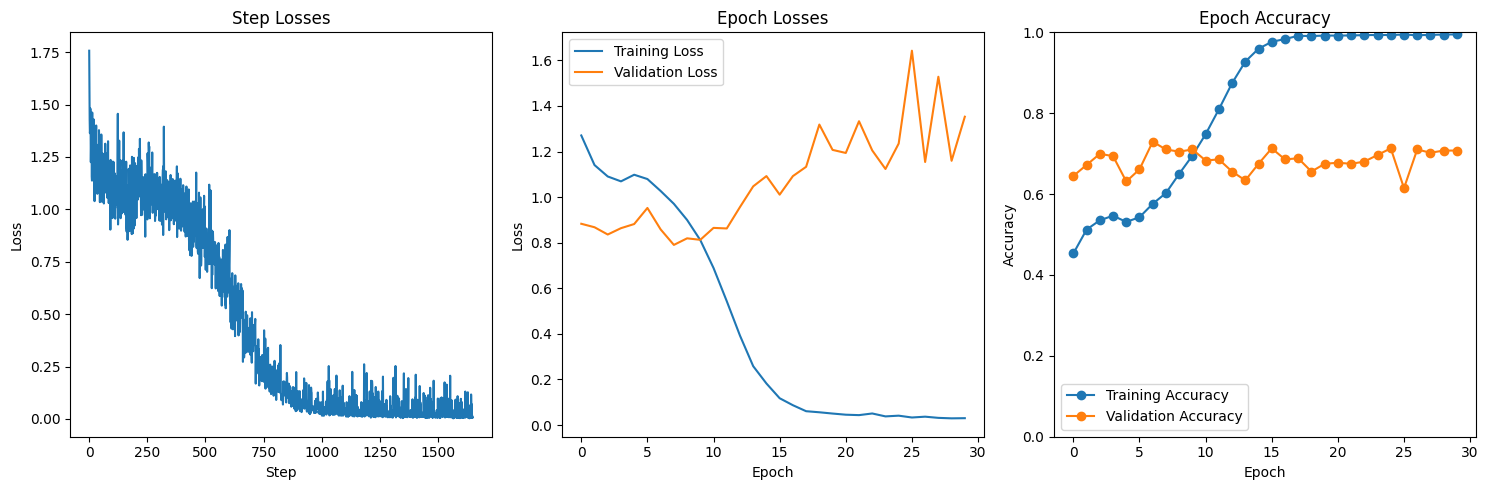

In [42]:
def model_fn():
    return RSGNet()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="RSGNet",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device,
        model_output_softmax = False
    )

# Simone's Model

In [65]:
class Simone(nn.Module):                                                                                                                                                                                
    def __init__(self):
        super(Simone, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*int(img_size/4)*int(img_size/4), out_features=128)
        self.dropout3 = nn.Dropout(p=0.5)  # 50% di dropout
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)  # applico dropout solo durante il training
        x = self.fc2(x)

        return x

In [66]:
model_simone = Simone()
print(model_simone)
summary(model_simone, input_size=(batch_size, 3, img_size, img_size))

Simone(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Simone                                   [64, 5]                   --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─Dropout: 1-2                           [64, 32, 224, 224]        --
├─Conv2d: 1-3                            [64, 64, 224, 224]        18,496
├─MaxPool2d: 1-4                         [64, 64, 112, 112]        --
├─Conv2d: 1-5                            [64, 128, 112, 112]       73,856
├─Dropout: 1-6                           [64, 128, 112, 112]       --
├─Conv2d: 1-7                            [64, 128, 112, 112]       147,584
├─MaxPool2d: 1-8                         [64, 128, 56, 56]         --
├─Linear: 1-9                            [64, 128]                 51,380,352
├─Dropout: 1-10                          [64, 128]                 --
├─Linear: 1-11                           [64, 5]                   645
Total params: 51,621,829
Trainable params: 51,621,829
Non-trai

In [ ]:
history, model_simone = train_model(
    model = model_simone,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    lr=1e-3,
    num_epochs = 30,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model_simone,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_simone")

Partono 18 esperimenti...

[1/18] Simone_run_001_optimizer_name=sgd_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6075 train acc=0.2017, validation loss: 1.6137 validation acc=0.2842
Epoch 2/30


Epoch 2 training loss: 1.6035 train acc=0.2400, validation loss: 1.6074 validation acc=0.2842
Epoch 3/30


Epoch 3 training loss: 1.6001 train acc=0.2817, validation loss: 1.6023 validation acc=0.2842
Epoch 4/30


Epoch 4 training loss: 1.5982 train acc=0.2834, validation loss: 1.5992 validation acc=0.2842
Epoch 5/30


Epoch 5 training loss: 1.5939 train acc=0.2980, validation loss: 1.5970 validation acc=0.2760
Epoch 6/30


Epoch 6 training loss: 1.5909 train acc=0.2943, validation loss: 1.5944 validation acc=0.3497
Epoch 7/30


Epoch 7 training loss: 1.5885 train acc=0.3134, validation loss: 1.5912 validation acc=0.4426
Epoch 8/30


Epoch 8 training loss: 1.5841 train acc=0.3046, validation loss: 1.5885 validation acc=0.5273
Epoch 9/30


Epoch 9 training loss: 1.5817 train acc=0.3220, validation loss: 1.5854 validation acc=0.5355
Epoch 10/30


Epoch 10 training loss: 1.5776 train acc=0.3389, validation loss: 1.5825 validation acc=0.5519
Epoch 11/30


Epoch 11 training loss: 1.5751 train acc=0.3271, validation loss: 1.5787 validation acc=0.6011
Epoch 12/30


Epoch 12 training loss: 1.5725 train acc=0.3486, validation loss: 1.5777 validation acc=0.6066
Epoch 13/30


Epoch 13 training loss: 1.5670 train acc=0.3660, validation loss: 1.5740 validation acc=0.6148
Epoch 14/30


Epoch 14 training loss: 1.5620 train acc=0.3643, validation loss: 1.5689 validation acc=0.6175
Epoch 15/30


Epoch 15 training loss: 1.5579 train acc=0.3760, validation loss: 1.5632 validation acc=0.6311
Epoch 16/30


Epoch 16 training loss: 1.5528 train acc=0.3769, validation loss: 1.5602 validation acc=0.6284
Epoch 17/30


Epoch 17 training loss: 1.5466 train acc=0.3826, validation loss: 1.5565 validation acc=0.6175
Epoch 18/30


Epoch 18 training loss: 1.5427 train acc=0.3883, validation loss: 1.5490 validation acc=0.6230
Epoch 19/30


Epoch 19 training loss: 1.5383 train acc=0.3834, validation loss: 1.5446 validation acc=0.6175
Epoch 20/30


Epoch 20 training loss: 1.5295 train acc=0.3966, validation loss: 1.5375 validation acc=0.6175
Epoch 21/30


Epoch 21 training loss: 1.5246 train acc=0.3980, validation loss: 1.5317 validation acc=0.6175
Epoch 22/30


Epoch 22 training loss: 1.5169 train acc=0.4049, validation loss: 1.5232 validation acc=0.6148
Epoch 23/30


Epoch 23 training loss: 1.5097 train acc=0.4034, validation loss: 1.5189 validation acc=0.6120
Epoch 24/30


Epoch 24 training loss: 1.5036 train acc=0.4080, validation loss: 1.5092 validation acc=0.6120
Epoch 25/30


Epoch 25 training loss: 1.4934 train acc=0.4054, validation loss: 1.5007 validation acc=0.6120
Epoch 26/30


Epoch 26 training loss: 1.4828 train acc=0.4191, validation loss: 1.4863 validation acc=0.6148
Epoch 27/30


Epoch 27 training loss: 1.4761 train acc=0.4140, validation loss: 1.4790 validation acc=0.6093
Epoch 28/30


Epoch 28 training loss: 1.4663 train acc=0.4191, validation loss: 1.4657 validation acc=0.6148
Epoch 29/30


Epoch 29 training loss: 1.4569 train acc=0.4237, validation loss: 1.4510 validation acc=0.6202
Epoch 30/30


Epoch 30 training loss: 1.4499 train acc=0.4171, validation loss: 1.4406 validation acc=0.6120
Test Accuracy: 65.85% | Precision: 0.284 | Recall: 0.341 | F1: 0.304
[2/18] Simone_run_002_optimizer_name=sgd_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0281 train acc=0.2174, validation loss: 1.0365 validation acc=0.1093
Epoch 2/30


Epoch 2 training loss: 1.0213 train acc=0.2791, validation loss: 1.0279 validation acc=0.1093
Epoch 3/30


Epoch 3 training loss: 1.0149 train acc=0.3091, validation loss: 1.0210 validation acc=0.1421
Epoch 4/30


Epoch 4 training loss: 1.0105 train acc=0.3303, validation loss: 1.0128 validation acc=0.2923
Epoch 5/30


Epoch 5 training loss: 1.0061 train acc=0.3326, validation loss: 1.0062 validation acc=0.4290
Epoch 6/30


Epoch 6 training loss: 0.9992 train acc=0.3431, validation loss: 1.0038 validation acc=0.4344
Epoch 7/30


Epoch 7 training loss: 0.9935 train acc=0.3494, validation loss: 0.9968 validation acc=0.4645
Epoch 8/30


Epoch 8 training loss: 0.9881 train acc=0.3614, validation loss: 0.9928 validation acc=0.4918
Epoch 9/30


Epoch 9 training loss: 0.9837 train acc=0.3623, validation loss: 0.9859 validation acc=0.5082
Epoch 10/30


Epoch 10 training loss: 0.9759 train acc=0.3854, validation loss: 0.9812 validation acc=0.5082
Epoch 11/30


Epoch 11 training loss: 0.9719 train acc=0.3803, validation loss: 0.9760 validation acc=0.5164
Epoch 12/30


Epoch 12 training loss: 0.9645 train acc=0.3900, validation loss: 0.9696 validation acc=0.5191
Epoch 13/30


Epoch 13 training loss: 0.9565 train acc=0.3914, validation loss: 0.9589 validation acc=0.5328
Epoch 14/30


Epoch 14 training loss: 0.9492 train acc=0.4071, validation loss: 0.9491 validation acc=0.5546
Epoch 15/30


Epoch 15 training loss: 0.9430 train acc=0.4040, validation loss: 0.9452 validation acc=0.5437
Epoch 16/30


Epoch 16 training loss: 0.9377 train acc=0.4031, validation loss: 0.9392 validation acc=0.5355
Epoch 17/30


Epoch 17 training loss: 0.9267 train acc=0.4086, validation loss: 0.9306 validation acc=0.5464
Epoch 18/30


Epoch 18 training loss: 0.9205 train acc=0.4137, validation loss: 0.9170 validation acc=0.5738
Epoch 19/30


Epoch 19 training loss: 0.9142 train acc=0.4091, validation loss: 0.9100 validation acc=0.5628
Epoch 20/30


Epoch 20 training loss: 0.9054 train acc=0.4063, validation loss: 0.9033 validation acc=0.5929
Epoch 21/30


Epoch 21 training loss: 0.8977 train acc=0.4120, validation loss: 0.8939 validation acc=0.5956
Epoch 22/30


Epoch 22 training loss: 0.8903 train acc=0.4220, validation loss: 0.8798 validation acc=0.6148
Epoch 23/30


Epoch 23 training loss: 0.8790 train acc=0.4189, validation loss: 0.8689 validation acc=0.6066
Epoch 24/30


Epoch 24 training loss: 0.8694 train acc=0.4311, validation loss: 0.8567 validation acc=0.6148
Epoch 25/30


Epoch 25 training loss: 0.8640 train acc=0.4189, validation loss: 0.8451 validation acc=0.6202
Epoch 26/30


Epoch 26 training loss: 0.8560 train acc=0.4266, validation loss: 0.8329 validation acc=0.6148
Epoch 27/30


Epoch 27 training loss: 0.8463 train acc=0.4234, validation loss: 0.8247 validation acc=0.6120
Epoch 28/30


Epoch 28 training loss: 0.8373 train acc=0.4214, validation loss: 0.8151 validation acc=0.6120
Epoch 29/30


Epoch 29 training loss: 0.8280 train acc=0.4371, validation loss: 0.7968 validation acc=0.6202
Epoch 30/30


Epoch 30 training loss: 0.8222 train acc=0.4311, validation loss: 0.7947 validation acc=0.6093
Test Accuracy: 66.39% | Precision: 0.358 | Recall: 0.360 | F1: 0.347
[3/18] Simone_run_003_optimizer_name=sgd_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6026 train acc=0.2431, validation loss: 1.5753 validation acc=0.5055
Epoch 2/30


Epoch 2 training loss: 1.5776 train acc=0.3194, validation loss: 1.5309 validation acc=0.6038
Epoch 3/30


Epoch 3 training loss: 1.5338 train acc=0.3577, validation loss: 1.4824 validation acc=0.6530
Epoch 4/30


Epoch 4 training loss: 1.4679 train acc=0.3869, validation loss: 1.3495 validation acc=0.6257
Epoch 5/30


Epoch 5 training loss: 1.3893 train acc=0.4109, validation loss: 1.2574 validation acc=0.5929
Epoch 6/30


Epoch 6 training loss: 1.3276 train acc=0.4183, validation loss: 1.1226 validation acc=0.6393
Epoch 7/30


Epoch 7 training loss: 1.2928 train acc=0.4226, validation loss: 1.0411 validation acc=0.6557
Epoch 8/30


Epoch 8 training loss: 1.2625 train acc=0.4520, validation loss: 1.0694 validation acc=0.6230
Epoch 9/30


Epoch 9 training loss: 1.2401 train acc=0.4594, validation loss: 1.0290 validation acc=0.6393
Epoch 10/30


Epoch 10 training loss: 1.2285 train acc=0.4631, validation loss: 1.0044 validation acc=0.6393
Epoch 11/30


Epoch 11 training loss: 1.2125 train acc=0.4697, validation loss: 0.9767 validation acc=0.6530
Epoch 12/30


Epoch 12 training loss: 1.2006 train acc=0.4731, validation loss: 0.9950 validation acc=0.6339
Epoch 13/30


Epoch 13 training loss: 1.1865 train acc=0.4863, validation loss: 0.9364 validation acc=0.6530
Epoch 14/30


Epoch 14 training loss: 1.1704 train acc=0.4900, validation loss: 0.9500 validation acc=0.6503
Epoch 15/30


Epoch 15 training loss: 1.1598 train acc=0.4897, validation loss: 0.9762 validation acc=0.6475
Epoch 16/30


Epoch 16 training loss: 1.1544 train acc=0.4937, validation loss: 1.0276 validation acc=0.6503
Epoch 17/30


Epoch 17 training loss: 1.1476 train acc=0.4966, validation loss: 0.9533 validation acc=0.6612
Epoch 18/30


Epoch 18 training loss: 1.1470 train acc=0.5011, validation loss: 0.9435 validation acc=0.6639
Epoch 19/30


Epoch 19 training loss: 1.1381 train acc=0.5054, validation loss: 0.9178 validation acc=0.6557
Epoch 20/30


Epoch 20 training loss: 1.1312 train acc=0.5091, validation loss: 0.8987 validation acc=0.6612
Epoch 21/30


Epoch 21 training loss: 1.1196 train acc=0.5226, validation loss: 0.8817 validation acc=0.6585
Epoch 22/30


Epoch 22 training loss: 1.1307 train acc=0.5140, validation loss: 0.9108 validation acc=0.6749
Epoch 23/30


Epoch 23 training loss: 1.1153 train acc=0.5214, validation loss: 0.9217 validation acc=0.6803
Epoch 24/30


Epoch 24 training loss: 1.1019 train acc=0.5257, validation loss: 0.8929 validation acc=0.6831
Epoch 25/30


Epoch 25 training loss: 1.1062 train acc=0.5146, validation loss: 0.8747 validation acc=0.6694
Epoch 26/30


Epoch 26 training loss: 1.0993 train acc=0.5280, validation loss: 0.8861 validation acc=0.6913
Epoch 27/30


Epoch 27 training loss: 1.0990 train acc=0.5294, validation loss: 0.8705 validation acc=0.6639
Epoch 28/30


Epoch 28 training loss: 1.0836 train acc=0.5251, validation loss: 0.8656 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 1.0907 train acc=0.5217, validation loss: 0.9335 validation acc=0.6749
Epoch 30/30


Epoch 30 training loss: 1.0776 train acc=0.5406, validation loss: 0.8530 validation acc=0.6721
Test Accuracy: 70.22% | Precision: 0.402 | Recall: 0.374 | F1: 0.330
[4/18] Simone_run_004_optimizer_name=sgd_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0160 train acc=0.2600, validation loss: 0.9940 validation acc=0.6066
Epoch 2/30


Epoch 2 training loss: 0.9765 train acc=0.3411, validation loss: 0.9396 validation acc=0.6311
Epoch 3/30


Epoch 3 training loss: 0.9245 train acc=0.3914, validation loss: 0.8803 validation acc=0.5984
Epoch 4/30


Epoch 4 training loss: 0.8657 train acc=0.4160, validation loss: 0.7851 validation acc=0.6366
Epoch 5/30


Epoch 5 training loss: 0.8065 train acc=0.4331, validation loss: 0.7081 validation acc=0.6257
Epoch 6/30


Epoch 6 training loss: 0.7666 train acc=0.4406, validation loss: 0.6624 validation acc=0.6284
Epoch 7/30


Epoch 7 training loss: 0.7412 train acc=0.4574, validation loss: 0.6262 validation acc=0.6475
Epoch 8/30


Epoch 8 training loss: 0.7209 train acc=0.4586, validation loss: 0.6016 validation acc=0.6475
Epoch 9/30


Epoch 9 training loss: 0.7030 train acc=0.4714, validation loss: 0.5700 validation acc=0.6639
Epoch 10/30


Epoch 10 training loss: 0.6968 train acc=0.4866, validation loss: 0.6128 validation acc=0.6366
Epoch 11/30


Epoch 11 training loss: 0.6824 train acc=0.4729, validation loss: 0.5586 validation acc=0.6639
Epoch 12/30


Epoch 12 training loss: 0.6799 train acc=0.4754, validation loss: 0.5723 validation acc=0.6503
Epoch 13/30


Epoch 13 training loss: 0.6663 train acc=0.4820, validation loss: 0.5454 validation acc=0.6612
Epoch 14/30


Epoch 14 training loss: 0.6543 train acc=0.5037, validation loss: 0.5476 validation acc=0.6612
Epoch 15/30


Epoch 15 training loss: 0.6484 train acc=0.5051, validation loss: 0.5420 validation acc=0.6585
Epoch 16/30


Epoch 16 training loss: 0.6412 train acc=0.5020, validation loss: 0.5476 validation acc=0.6585
Epoch 17/30


Epoch 17 training loss: 0.6376 train acc=0.5060, validation loss: 0.5556 validation acc=0.6721
Epoch 18/30


Epoch 18 training loss: 0.6259 train acc=0.5149, validation loss: 0.5174 validation acc=0.6667
Epoch 19/30


Epoch 19 training loss: 0.6230 train acc=0.5160, validation loss: 0.5387 validation acc=0.6585
Epoch 20/30


Epoch 20 training loss: 0.6130 train acc=0.5263, validation loss: 0.5351 validation acc=0.6721
Epoch 21/30


Epoch 21 training loss: 0.6160 train acc=0.5183, validation loss: 0.5248 validation acc=0.6721
Epoch 22/30


Epoch 22 training loss: 0.6075 train acc=0.5154, validation loss: 0.5303 validation acc=0.6721
Epoch 23/30


Epoch 23 training loss: 0.5949 train acc=0.5226, validation loss: 0.4953 validation acc=0.6885
Epoch 24/30


Epoch 24 training loss: 0.6002 train acc=0.5246, validation loss: 0.5096 validation acc=0.6694
Epoch 25/30


Epoch 25 training loss: 0.6000 train acc=0.5274, validation loss: 0.5003 validation acc=0.6667
Epoch 26/30


Epoch 26 training loss: 0.5901 train acc=0.5317, validation loss: 0.5148 validation acc=0.6885
Epoch 27/30


Epoch 27 training loss: 0.5851 train acc=0.5346, validation loss: 0.5018 validation acc=0.6776
Epoch 28/30


Epoch 28 training loss: 0.5786 train acc=0.5331, validation loss: 0.5069 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.5788 train acc=0.5323, validation loss: 0.5105 validation acc=0.6749
Epoch 30/30


Epoch 30 training loss: 0.5751 train acc=0.5414, validation loss: 0.4807 validation acc=0.6803
Test Accuracy: 71.31% | Precision: 0.281 | Recall: 0.361 | F1: 0.308
[5/18] Simone_run_005_optimizer_name=sgd_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.5719 train acc=0.2857, validation loss: 1.4592 validation acc=0.5519
Epoch 2/30


Epoch 2 training loss: 1.3997 train acc=0.3840, validation loss: 1.0491 validation acc=0.6475
Epoch 3/30


Epoch 3 training loss: 1.2982 train acc=0.4323, validation loss: 1.0315 validation acc=0.6257
Epoch 4/30


Epoch 4 training loss: 1.2568 train acc=0.4460, validation loss: 0.9586 validation acc=0.6530
Epoch 5/30


Epoch 5 training loss: 1.2161 train acc=0.4694, validation loss: 0.9810 validation acc=0.6366
Epoch 6/30


Epoch 6 training loss: 1.1987 train acc=0.4717, validation loss: 0.8895 validation acc=0.6585
Epoch 7/30


Epoch 7 training loss: 1.1746 train acc=0.4931, validation loss: 0.9192 validation acc=0.6503
Epoch 8/30


Epoch 8 training loss: 1.1702 train acc=0.5063, validation loss: 0.8809 validation acc=0.6557
Epoch 9/30


Epoch 9 training loss: 1.1443 train acc=0.5077, validation loss: 0.9152 validation acc=0.6585
Epoch 10/30


Epoch 10 training loss: 1.1379 train acc=0.5029, validation loss: 0.9654 validation acc=0.6639
Epoch 11/30


Epoch 11 training loss: 1.1422 train acc=0.5051, validation loss: 0.9008 validation acc=0.6612
Epoch 12/30


Epoch 12 training loss: 1.1257 train acc=0.5100, validation loss: 0.9591 validation acc=0.6366
Epoch 13/30


Epoch 13 training loss: 1.1257 train acc=0.5020, validation loss: 0.9542 validation acc=0.6503
Epoch 14/30


Epoch 14 training loss: 1.1139 train acc=0.5149, validation loss: 0.9483 validation acc=0.6585
Epoch 15/30


Epoch 15 training loss: 1.1111 train acc=0.5169, validation loss: 0.9287 validation acc=0.6393
Epoch 16/30


Epoch 16 training loss: 1.0900 train acc=0.5289, validation loss: 0.8974 validation acc=0.6585
Epoch 17/30


Epoch 17 training loss: 1.0848 train acc=0.5134, validation loss: 0.9739 validation acc=0.6230
Epoch 18/30


Epoch 18 training loss: 1.0792 train acc=0.5234, validation loss: 0.9616 validation acc=0.6639
Epoch 19/30


Epoch 19 training loss: 1.0718 train acc=0.5423, validation loss: 0.8351 validation acc=0.6885
Epoch 20/30


Epoch 20 training loss: 1.0491 train acc=0.5389, validation loss: 0.8718 validation acc=0.6694
Epoch 21/30


Epoch 21 training loss: 1.0584 train acc=0.5449, validation loss: 0.8264 validation acc=0.6885
Epoch 22/30


Epoch 22 training loss: 1.0479 train acc=0.5623, validation loss: 0.8294 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 1.0518 train acc=0.5497, validation loss: 0.8997 validation acc=0.6612
Epoch 24/30


Epoch 24 training loss: 1.0414 train acc=0.5551, validation loss: 0.8437 validation acc=0.6940
Epoch 25/30


Epoch 25 training loss: 1.0392 train acc=0.5526, validation loss: 0.9283 validation acc=0.6721
Epoch 26/30


Epoch 26 training loss: 1.0427 train acc=0.5531, validation loss: 0.8696 validation acc=0.6694
Epoch 27/30


Epoch 27 training loss: 1.0330 train acc=0.5626, validation loss: 0.8826 validation acc=0.6967
Epoch 28/30


Epoch 28 training loss: 1.0316 train acc=0.5443, validation loss: 0.9959 validation acc=0.6284
Epoch 29/30


Epoch 29 training loss: 1.0342 train acc=0.5540, validation loss: 0.8578 validation acc=0.6995
Epoch 30/30


Epoch 30 training loss: 1.0067 train acc=0.5597, validation loss: 0.8095 validation acc=0.6776
Test Accuracy: 73.22% | Precision: 0.429 | Recall: 0.427 | F1: 0.415
[6/18] Simone_run_006_optimizer_name=sgd_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0132 train acc=0.2509, validation loss: 0.9614 validation acc=0.6585
Epoch 2/30


Epoch 2 training loss: 0.9315 train acc=0.3469, validation loss: 0.7828 validation acc=0.6612
Epoch 3/30


Epoch 3 training loss: 0.8254 train acc=0.3917, validation loss: 0.6637 validation acc=0.6311
Epoch 4/30


Epoch 4 training loss: 0.7648 train acc=0.4169, validation loss: 0.6227 validation acc=0.6284
Epoch 5/30


Epoch 5 training loss: 0.7419 train acc=0.4494, validation loss: 0.6110 validation acc=0.5929
Epoch 6/30


Epoch 6 training loss: 0.7221 train acc=0.4417, validation loss: 0.5638 validation acc=0.6475
Epoch 7/30


Epoch 7 training loss: 0.7005 train acc=0.4646, validation loss: 0.6054 validation acc=0.6011
Epoch 8/30


Epoch 8 training loss: 0.6817 train acc=0.4754, validation loss: 0.5824 validation acc=0.6475
Epoch 9/30


Epoch 9 training loss: 0.6669 train acc=0.4769, validation loss: 0.5466 validation acc=0.6557
Epoch 10/30


Epoch 10 training loss: 0.6565 train acc=0.4849, validation loss: 0.5949 validation acc=0.5464
Epoch 11/30


Epoch 11 training loss: 0.6435 train acc=0.4909, validation loss: 0.5320 validation acc=0.6557
Epoch 12/30


Epoch 12 training loss: 0.6395 train acc=0.4914, validation loss: 0.5247 validation acc=0.6530
Epoch 13/30


Epoch 13 training loss: 0.6299 train acc=0.5114, validation loss: 0.5657 validation acc=0.6503
Epoch 14/30


Epoch 14 training loss: 0.6217 train acc=0.5094, validation loss: 0.5458 validation acc=0.6448
Epoch 15/30


Epoch 15 training loss: 0.6121 train acc=0.5023, validation loss: 0.4693 validation acc=0.6831
Epoch 16/30


Epoch 16 training loss: 0.6043 train acc=0.5069, validation loss: 0.4831 validation acc=0.6831
Epoch 17/30


Epoch 17 training loss: 0.5935 train acc=0.5109, validation loss: 0.4792 validation acc=0.6913
Epoch 18/30


Epoch 18 training loss: 0.5926 train acc=0.5034, validation loss: 0.4740 validation acc=0.6749
Epoch 19/30


Epoch 19 training loss: 0.5849 train acc=0.5103, validation loss: 0.4619 validation acc=0.6885
Epoch 20/30


Epoch 20 training loss: 0.5778 train acc=0.5160, validation loss: 0.4969 validation acc=0.6639
Epoch 21/30


Epoch 21 training loss: 0.5756 train acc=0.5131, validation loss: 0.4804 validation acc=0.6913
Epoch 22/30


Epoch 22 training loss: 0.5781 train acc=0.5223, validation loss: 0.5151 validation acc=0.6831
Epoch 23/30


Epoch 23 training loss: 0.5692 train acc=0.5174, validation loss: 0.5381 validation acc=0.6557
Epoch 24/30


Epoch 24 training loss: 0.5662 train acc=0.5251, validation loss: 0.4789 validation acc=0.6885
Epoch 25/30


Epoch 25 training loss: 0.5617 train acc=0.5191, validation loss: 0.4851 validation acc=0.6694
Epoch 26/30


Epoch 26 training loss: 0.5583 train acc=0.5266, validation loss: 0.5060 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.5533 train acc=0.5326, validation loss: 0.4719 validation acc=0.6967
Epoch 28/30


Epoch 28 training loss: 0.5487 train acc=0.5383, validation loss: 0.4829 validation acc=0.6940
Epoch 29/30


Epoch 29 training loss: 0.5542 train acc=0.5266, validation loss: 0.4912 validation acc=0.6831
Epoch 30/30


Epoch 30 training loss: 0.5497 train acc=0.5411, validation loss: 0.4780 validation acc=0.6749
Test Accuracy: 72.68% | Precision: 0.415 | Recall: 0.418 | F1: 0.402
[7/18] Simone_run_007_optimizer_name=adam_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.5210 train acc=0.3440, validation loss: 1.1242 validation acc=0.6585
Epoch 2/30


Epoch 2 training loss: 1.2836 train acc=0.4271, validation loss: 0.9732 validation acc=0.6612
Epoch 3/30


Epoch 3 training loss: 1.2247 train acc=0.4557, validation loss: 0.9373 validation acc=0.6721
Epoch 4/30


Epoch 4 training loss: 1.1975 train acc=0.4677, validation loss: 0.9539 validation acc=0.6803
Epoch 5/30


Epoch 5 training loss: 1.1816 train acc=0.4794, validation loss: 0.9679 validation acc=0.6421
Epoch 6/30


Epoch 6 training loss: 1.1669 train acc=0.4863, validation loss: 0.8991 validation acc=0.6749
Epoch 7/30


Epoch 7 training loss: 1.1221 train acc=0.5100, validation loss: 0.8917 validation acc=0.6858
Epoch 8/30


Epoch 8 training loss: 1.1037 train acc=0.5103, validation loss: 0.8955 validation acc=0.6858
Epoch 9/30


Epoch 9 training loss: 1.0926 train acc=0.5351, validation loss: 0.9027 validation acc=0.6913
Epoch 10/30


Epoch 10 training loss: 1.0493 train acc=0.5411, validation loss: 0.9031 validation acc=0.7131
Epoch 11/30


Epoch 11 training loss: 1.0137 train acc=0.5706, validation loss: 0.9005 validation acc=0.6667
Epoch 12/30


Epoch 12 training loss: 0.9963 train acc=0.5657, validation loss: 0.8547 validation acc=0.7077
Epoch 13/30


Epoch 13 training loss: 0.9624 train acc=0.5900, validation loss: 0.8156 validation acc=0.6967
Epoch 14/30


Epoch 14 training loss: 0.9268 train acc=0.5966, validation loss: 0.7804 validation acc=0.7104
Epoch 15/30


Epoch 15 training loss: 0.8719 train acc=0.6323, validation loss: 0.7841 validation acc=0.7131
Epoch 16/30


Epoch 16 training loss: 0.8159 train acc=0.6477, validation loss: 0.8107 validation acc=0.7240
Epoch 17/30


Epoch 17 training loss: 0.7228 train acc=0.6903, validation loss: 0.7960 validation acc=0.7077
Epoch 18/30


Epoch 18 training loss: 0.6708 train acc=0.7097, validation loss: 0.8852 validation acc=0.6913
Epoch 19/30


Epoch 19 training loss: 0.6457 train acc=0.7269, validation loss: 0.8586 validation acc=0.7049
Epoch 20/30


Epoch 20 training loss: 0.5761 train acc=0.7586, validation loss: 0.8446 validation acc=0.7022
Epoch 21/30


Epoch 21 training loss: 0.5280 train acc=0.7737, validation loss: 0.8827 validation acc=0.7104
Epoch 22/30


Epoch 22 training loss: 0.4807 train acc=0.7920, validation loss: 0.9439 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 0.4427 train acc=0.8106, validation loss: 1.0318 validation acc=0.7158
Epoch 24/30


Epoch 24 training loss: 0.4116 train acc=0.8231, validation loss: 1.0219 validation acc=0.7158
Epoch 25/30


Epoch 25 training loss: 0.3885 train acc=0.8329, validation loss: 1.0227 validation acc=0.7213
Epoch 26/30


Epoch 26 training loss: 0.3779 train acc=0.8366, validation loss: 1.0301 validation acc=0.6995
Epoch 27/30


Epoch 27 training loss: 0.3603 train acc=0.8420, validation loss: 1.0885 validation acc=0.7213
Epoch 28/30


Epoch 28 training loss: 0.3419 train acc=0.8434, validation loss: 1.2885 validation acc=0.6967
Epoch 29/30


Epoch 29 training loss: 0.3136 train acc=0.8620, validation loss: 1.2872 validation acc=0.7077
Epoch 30/30


Epoch 30 training loss: 0.3090 train acc=0.8683, validation loss: 1.2146 validation acc=0.7213
Test Accuracy: 72.68% | Precision: 0.494 | Recall: 0.500 | F1: 0.481
[8/18] Simone_run_008_optimizer_name=adam_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.9208 train acc=0.3551, validation loss: 0.6282 validation acc=0.6421
Epoch 2/30


Epoch 2 training loss: 0.7259 train acc=0.4489, validation loss: 0.5395 validation acc=0.6612
Epoch 3/30


Epoch 3 training loss: 0.6898 train acc=0.4746, validation loss: 0.5674 validation acc=0.6639
Epoch 4/30


Epoch 4 training loss: 0.6596 train acc=0.4849, validation loss: 0.5111 validation acc=0.6667
Epoch 5/30


Epoch 5 training loss: 0.6311 train acc=0.4937, validation loss: 0.5186 validation acc=0.6776
Epoch 6/30


Epoch 6 training loss: 0.5971 train acc=0.5200, validation loss: 0.5265 validation acc=0.7158
Epoch 7/30


Epoch 7 training loss: 0.5647 train acc=0.5357, validation loss: 0.4979 validation acc=0.7158
Epoch 8/30


Epoch 8 training loss: 0.5369 train acc=0.5694, validation loss: 0.4644 validation acc=0.7158
Epoch 9/30


Epoch 9 training loss: 0.5006 train acc=0.5840, validation loss: 0.4532 validation acc=0.7186
Epoch 10/30


Epoch 10 training loss: 0.4627 train acc=0.6211, validation loss: 0.4254 validation acc=0.7295
Epoch 11/30


Epoch 11 training loss: 0.4109 train acc=0.6449, validation loss: 0.4489 validation acc=0.7295
Epoch 12/30


Epoch 12 training loss: 0.3709 train acc=0.6800, validation loss: 0.4423 validation acc=0.7404
Epoch 13/30


Epoch 13 training loss: 0.3356 train acc=0.7029, validation loss: 0.4642 validation acc=0.7295
Epoch 14/30


Epoch 14 training loss: 0.3027 train acc=0.7217, validation loss: 0.5024 validation acc=0.7022
Epoch 15/30


Epoch 15 training loss: 0.2640 train acc=0.7603, validation loss: 0.5309 validation acc=0.7213
Epoch 16/30


Epoch 16 training loss: 0.2272 train acc=0.7866, validation loss: 0.5286 validation acc=0.7322
Epoch 17/30


Epoch 17 training loss: 0.2003 train acc=0.8083, validation loss: 0.5205 validation acc=0.7158
Epoch 18/30


Epoch 18 training loss: 0.1914 train acc=0.8291, validation loss: 0.5439 validation acc=0.7322
Epoch 19/30


Epoch 19 training loss: 0.1593 train acc=0.8434, validation loss: 0.6841 validation acc=0.7432
Epoch 20/30


Epoch 20 training loss: 0.1576 train acc=0.8394, validation loss: 0.6195 validation acc=0.6967
Epoch 21/30


Epoch 21 training loss: 0.1326 train acc=0.8657, validation loss: 0.6934 validation acc=0.7295
Epoch 22/30


Epoch 22 training loss: 0.1211 train acc=0.8771, validation loss: 0.6412 validation acc=0.7186
Epoch 23/30


Epoch 23 training loss: 0.1095 train acc=0.8871, validation loss: 0.7208 validation acc=0.6940
Epoch 24/30


Epoch 24 training loss: 0.1172 train acc=0.8774, validation loss: 0.7272 validation acc=0.7268
Epoch 25/30


Epoch 25 training loss: 0.1040 train acc=0.8869, validation loss: 0.7650 validation acc=0.7213
Epoch 26/30


Epoch 26 training loss: 0.0940 train acc=0.8966, validation loss: 0.7347 validation acc=0.7213
Epoch 27/30


Epoch 27 training loss: 0.0917 train acc=0.8957, validation loss: 0.8027 validation acc=0.7240
Epoch 28/30


Epoch 28 training loss: 0.0977 train acc=0.8974, validation loss: 0.7913 validation acc=0.7131
Epoch 29/30


Epoch 29 training loss: 0.0839 train acc=0.9134, validation loss: 0.8406 validation acc=0.7213
Epoch 30/30


Epoch 30 training loss: 0.0775 train acc=0.9169, validation loss: 0.8927 validation acc=0.7158
Test Accuracy: 72.68% | Precision: 0.473 | Recall: 0.477 | F1: 0.470
[9/18] Simone_run_009_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.8625 train acc=0.3357, validation loss: 0.9995 validation acc=0.6066
Epoch 2/30


Epoch 2 training loss: 1.2880 train acc=0.4409, validation loss: 1.0125 validation acc=0.6202
Epoch 3/30


Epoch 3 training loss: 1.2191 train acc=0.4706, validation loss: 0.8951 validation acc=0.6475
Epoch 4/30


Epoch 4 training loss: 1.1994 train acc=0.4760, validation loss: 0.9831 validation acc=0.6421
Epoch 5/30


Epoch 5 training loss: 1.1640 train acc=0.4929, validation loss: 0.9435 validation acc=0.6639
Epoch 6/30


Epoch 6 training loss: 1.1369 train acc=0.5020, validation loss: 0.8998 validation acc=0.6393
Epoch 7/30


Epoch 7 training loss: 1.1258 train acc=0.5074, validation loss: 1.0170 validation acc=0.6475
Epoch 8/30


Epoch 8 training loss: 1.1134 train acc=0.5151, validation loss: 0.8966 validation acc=0.6530
Epoch 9/30


Epoch 9 training loss: 1.1050 train acc=0.5200, validation loss: 0.8968 validation acc=0.6776
Epoch 10/30


Epoch 10 training loss: 1.0981 train acc=0.5160, validation loss: 0.8789 validation acc=0.6776
Epoch 11/30


Epoch 11 training loss: 1.0932 train acc=0.5203, validation loss: 0.8505 validation acc=0.6503
Epoch 12/30


Epoch 12 training loss: 1.0715 train acc=0.5283, validation loss: 0.8217 validation acc=0.6940
Epoch 13/30


Epoch 13 training loss: 1.0593 train acc=0.5351, validation loss: 0.8861 validation acc=0.6803
Epoch 14/30


Epoch 14 training loss: 1.0533 train acc=0.5317, validation loss: 0.8146 validation acc=0.6694
Epoch 15/30


Epoch 15 training loss: 1.0448 train acc=0.5391, validation loss: 0.8032 validation acc=0.6776
Epoch 16/30


Epoch 16 training loss: 1.0277 train acc=0.5560, validation loss: 0.8534 validation acc=0.6639
Epoch 17/30


Epoch 17 training loss: 1.0061 train acc=0.5503, validation loss: 0.8277 validation acc=0.6776
Epoch 18/30


Epoch 18 training loss: 0.9911 train acc=0.5649, validation loss: 0.7945 validation acc=0.6940
Epoch 19/30


Epoch 19 training loss: 0.9781 train acc=0.5669, validation loss: 0.8216 validation acc=0.6831
Epoch 20/30


Epoch 20 training loss: 0.9624 train acc=0.5734, validation loss: 0.8020 validation acc=0.6940
Epoch 21/30


Epoch 21 training loss: 0.9279 train acc=0.6014, validation loss: 0.8223 validation acc=0.6776
Epoch 22/30


Epoch 22 training loss: 0.8904 train acc=0.6169, validation loss: 0.8277 validation acc=0.6885
Epoch 23/30


Epoch 23 training loss: 0.8769 train acc=0.6260, validation loss: 0.8772 validation acc=0.6967
Epoch 24/30


Epoch 24 training loss: 0.8537 train acc=0.6286, validation loss: 0.8462 validation acc=0.6913
Epoch 25/30


Epoch 25 training loss: 0.8061 train acc=0.6534, validation loss: 0.9991 validation acc=0.6749
Epoch 26/30


Epoch 26 training loss: 0.7525 train acc=0.6729, validation loss: 1.0442 validation acc=0.6721
Epoch 27/30


Epoch 27 training loss: 0.7514 train acc=0.6680, validation loss: 1.0385 validation acc=0.6585
Epoch 28/30


Epoch 28 training loss: 0.7168 train acc=0.6829, validation loss: 1.2066 validation acc=0.6749
Epoch 29/30


Epoch 29 training loss: 0.6762 train acc=0.7097, validation loss: 1.1580 validation acc=0.6530
Epoch 30/30


Epoch 30 training loss: 0.6585 train acc=0.7126, validation loss: 1.1390 validation acc=0.6776
Test Accuracy: 72.68% | Precision: 0.524 | Recall: 0.495 | F1: 0.491
[10/18] Simone_run_010_optimizer_name=adam_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.5281 train acc=0.2737, validation loss: 0.7312 validation acc=0.5546
Epoch 2/30


Epoch 2 training loss: 0.7669 train acc=0.4271, validation loss: 0.5349 validation acc=0.6557
Epoch 3/30


Epoch 3 training loss: 0.6890 train acc=0.4563, validation loss: 0.6076 validation acc=0.6202
Epoch 4/30


Epoch 4 training loss: 0.6636 train acc=0.4746, validation loss: 0.4993 validation acc=0.6803
Epoch 5/30


Epoch 5 training loss: 0.6506 train acc=0.4726, validation loss: 0.4890 validation acc=0.6503
Epoch 6/30


Epoch 6 training loss: 0.6223 train acc=0.4937, validation loss: 0.5714 validation acc=0.6858
Epoch 7/30


Epoch 7 training loss: 0.6134 train acc=0.4909, validation loss: 0.5445 validation acc=0.6749
Epoch 8/30


Epoch 8 training loss: 0.5951 train acc=0.5074, validation loss: 0.4940 validation acc=0.6803
Epoch 9/30


Epoch 9 training loss: 0.5994 train acc=0.4866, validation loss: 0.5014 validation acc=0.6913
Epoch 10/30


Epoch 10 training loss: 0.5846 train acc=0.5174, validation loss: 0.4875 validation acc=0.6530
Epoch 11/30


Epoch 11 training loss: 0.5751 train acc=0.5046, validation loss: 0.4798 validation acc=0.6749
Epoch 12/30


Epoch 12 training loss: 0.5769 train acc=0.5269, validation loss: 0.5184 validation acc=0.6721
Epoch 13/30


Epoch 13 training loss: 0.5803 train acc=0.5091, validation loss: 0.5244 validation acc=0.6557
Epoch 14/30


Epoch 14 training loss: 0.5605 train acc=0.5300, validation loss: 0.4522 validation acc=0.6694
Epoch 15/30


Epoch 15 training loss: 0.5507 train acc=0.5326, validation loss: 0.4866 validation acc=0.6967
Epoch 16/30


Epoch 16 training loss: 0.5515 train acc=0.5200, validation loss: 0.4415 validation acc=0.6831
Epoch 17/30


Epoch 17 training loss: 0.5484 train acc=0.5389, validation loss: 0.4523 validation acc=0.6831
Epoch 18/30


Epoch 18 training loss: 0.5382 train acc=0.5434, validation loss: 0.4369 validation acc=0.6831
Epoch 19/30


Epoch 19 training loss: 0.5118 train acc=0.5566, validation loss: 0.4433 validation acc=0.6913
Epoch 20/30


Epoch 20 training loss: 0.5162 train acc=0.5546, validation loss: 0.4306 validation acc=0.6885
Epoch 21/30


Epoch 21 training loss: 0.4996 train acc=0.5531, validation loss: 0.4167 validation acc=0.6995
Epoch 22/30


Epoch 22 training loss: 0.4990 train acc=0.5551, validation loss: 0.4575 validation acc=0.6667
Epoch 23/30


Epoch 23 training loss: 0.4859 train acc=0.5757, validation loss: 0.4328 validation acc=0.6885
Epoch 24/30


Epoch 24 training loss: 0.4777 train acc=0.5740, validation loss: 0.4686 validation acc=0.6721
Epoch 25/30


Epoch 25 training loss: 0.4596 train acc=0.5834, validation loss: 0.4298 validation acc=0.7049
Epoch 26/30


Epoch 26 training loss: 0.4495 train acc=0.5909, validation loss: 0.4402 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.4259 train acc=0.6040, validation loss: 0.5131 validation acc=0.6530
Epoch 28/30


Epoch 28 training loss: 0.4322 train acc=0.5971, validation loss: 0.5199 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.3832 train acc=0.6277, validation loss: 0.5049 validation acc=0.6913
Epoch 30/30


Epoch 30 training loss: 0.3867 train acc=0.6451, validation loss: 0.5456 validation acc=0.6940
Test Accuracy: 70.77% | Precision: 0.445 | Recall: 0.422 | F1: 0.406
[11/18] Simone_run_011_optimizer_name=adam_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 7.2826 train acc=0.1923, validation loss: 1.6153 validation acc=0.0765
Epoch 2/30


Epoch 2 training loss: 1.6102 train acc=0.1909, validation loss: 1.6132 validation acc=0.1093
Epoch 3/30


Epoch 3 training loss: 1.6103 train acc=0.1889, validation loss: 1.6114 validation acc=0.0601
Epoch 4/30


Epoch 4 training loss: 1.6100 train acc=0.1960, validation loss: 1.6148 validation acc=0.0765
Epoch 5/30


Epoch 5 training loss: 1.6099 train acc=0.1943, validation loss: 1.6101 validation acc=0.0765
Epoch 6/30


Epoch 6 training loss: 1.6097 train acc=0.1957, validation loss: 1.6104 validation acc=0.0601
Epoch 7/30


Epoch 7 training loss: 1.6098 train acc=0.1983, validation loss: 1.6102 validation acc=0.1093
Epoch 8/30


Epoch 8 training loss: 1.6098 train acc=0.1969, validation loss: 1.6088 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 1.6098 train acc=0.1946, validation loss: 1.6105 validation acc=0.2842
Epoch 10/30


Epoch 10 training loss: 1.6101 train acc=0.1886, validation loss: 1.6111 validation acc=0.0765
Epoch 11/30


Epoch 11 training loss: 1.6097 train acc=0.1983, validation loss: 1.6113 validation acc=0.0765
Epoch 12/30


Epoch 12 training loss: 1.6097 train acc=0.1897, validation loss: 1.6061 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 1.6101 train acc=0.1931, validation loss: 1.6101 validation acc=0.1093
Epoch 14/30


Epoch 14 training loss: 1.6101 train acc=0.1929, validation loss: 1.6110 validation acc=0.1093
Epoch 15/30


Epoch 15 training loss: 1.6098 train acc=0.1943, validation loss: 1.6082 validation acc=0.2842
Epoch 16/30


Epoch 16 training loss: 1.6097 train acc=0.1974, validation loss: 1.6114 validation acc=0.0765
Epoch 17/30


Epoch 17 training loss: 1.6098 train acc=0.1891, validation loss: 1.6116 validation acc=0.0601
Epoch 18/30


Epoch 18 training loss: 1.6101 train acc=0.1863, validation loss: 1.6118 validation acc=0.1093
Epoch 19/30


Epoch 19 training loss: 1.6100 train acc=0.1871, validation loss: 1.6073 validation acc=0.4699
Epoch 20/30


Epoch 20 training loss: 1.6096 train acc=0.1991, validation loss: 1.6069 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 1.6099 train acc=0.2066, validation loss: 1.6053 validation acc=0.2842
Epoch 22/30


Epoch 22 training loss: 1.6100 train acc=0.1891, validation loss: 1.6068 validation acc=0.4699
Epoch 23/30


Epoch 23 training loss: 1.6100 train acc=0.1894, validation loss: 1.6067 validation acc=0.1093
Epoch 24/30


Epoch 24 training loss: 1.6098 train acc=0.1851, validation loss: 1.6115 validation acc=0.2842
Epoch 25/30


Epoch 25 training loss: 1.6098 train acc=0.1943, validation loss: 1.6086 validation acc=0.0765
Epoch 26/30


Epoch 26 training loss: 1.6098 train acc=0.1917, validation loss: 1.6135 validation acc=0.2842
Epoch 27/30


Epoch 27 training loss: 1.6097 train acc=0.1974, validation loss: 1.6094 validation acc=0.4699
Epoch 28/30


Epoch 28 training loss: 1.6099 train acc=0.1911, validation loss: 1.6102 validation acc=0.0601
Epoch 29/30


Epoch 29 training loss: 1.6098 train acc=0.1889, validation loss: 1.6101 validation acc=0.1093
Epoch 30/30


Epoch 30 training loss: 1.6099 train acc=0.2014, validation loss: 1.6116 validation acc=0.0765
Test Accuracy: 9.02% | Precision: 0.018 | Recall: 0.200 | F1: 0.033
[12/18] Simone_run_012_optimizer_name=adam_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 29.0043 train acc=0.1986, validation loss: 34.6180 validation acc=0.0601
Epoch 2/30


Epoch 2 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 3/30


Epoch 3 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 4/30


Epoch 4 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 5/30


Epoch 5 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 6/30


Epoch 6 training loss: 29.4626 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 7/30


Epoch 7 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 8/30


Epoch 8 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 29.4864 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 10/30


Epoch 10 training loss: 29.4531 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 11/30


Epoch 11 training loss: 29.4531 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 12/30


Epoch 12 training loss: 29.4912 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 13/30


Epoch 13 training loss: 29.5007 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 14/30


Epoch 14 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 15/30


Epoch 15 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 16/30


Epoch 16 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 17/30


Epoch 17 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 18/30


Epoch 18 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 19/30


Epoch 19 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 20/30


Epoch 20 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 21/30


Epoch 21 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 22/30


Epoch 22 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 23/30


Epoch 23 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 24/30


Epoch 24 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 25/30


Epoch 25 training loss: 29.4474 train acc=0.2003, validation loss: 34.6180 validation acc=0.0601
Epoch 26/30


Epoch 26 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 27/30


Epoch 27 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 28/30


Epoch 28 training loss: 29.4531 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 29/30


Epoch 29 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 30/30


Epoch 30 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Test Accuracy: 4.64% | Precision: 0.009 | Recall: 0.200 | F1: 0.018
[13/18] Simone_run_013_optimizer_name=adamw_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4704 train acc=0.3560, validation loss: 1.0496 validation acc=0.6448
Epoch 2/30


Epoch 2 training loss: 1.2551 train acc=0.4589, validation loss: 1.0536 validation acc=0.6284
Epoch 3/30


Epoch 3 training loss: 1.2060 train acc=0.4754, validation loss: 0.9505 validation acc=0.6421
Epoch 4/30


Epoch 4 training loss: 1.1883 train acc=0.4920, validation loss: 1.0082 validation acc=0.6530
Epoch 5/30


Epoch 5 training loss: 1.1414 train acc=0.5286, validation loss: 0.9960 validation acc=0.6339
Epoch 6/30


Epoch 6 training loss: 1.1201 train acc=0.5129, validation loss: 0.9234 validation acc=0.6913
Epoch 7/30


Epoch 7 training loss: 1.1011 train acc=0.5243, validation loss: 0.8667 validation acc=0.6885
Epoch 8/30


Epoch 8 training loss: 1.0688 train acc=0.5471, validation loss: 0.9221 validation acc=0.6995
Epoch 9/30


Epoch 9 training loss: 1.0390 train acc=0.5517, validation loss: 1.0101 validation acc=0.6940
Epoch 10/30


Epoch 10 training loss: 1.0007 train acc=0.5849, validation loss: 0.9060 validation acc=0.7049
Epoch 11/30


Epoch 11 training loss: 0.9220 train acc=0.6166, validation loss: 0.8320 validation acc=0.7131
Epoch 12/30


Epoch 12 training loss: 0.8811 train acc=0.6257, validation loss: 0.7934 validation acc=0.7131
Epoch 13/30


Epoch 13 training loss: 0.7875 train acc=0.6720, validation loss: 0.8401 validation acc=0.6967
Epoch 14/30


Epoch 14 training loss: 0.7393 train acc=0.6991, validation loss: 0.7829 validation acc=0.7158
Epoch 15/30


Epoch 15 training loss: 0.6608 train acc=0.7369, validation loss: 0.7984 validation acc=0.7104
Epoch 16/30


Epoch 16 training loss: 0.5930 train acc=0.7537, validation loss: 0.8378 validation acc=0.7158
Epoch 17/30


Epoch 17 training loss: 0.5414 train acc=0.7820, validation loss: 0.7981 validation acc=0.7295
Epoch 18/30


Epoch 18 training loss: 0.5065 train acc=0.7854, validation loss: 0.8944 validation acc=0.7186
Epoch 19/30


Epoch 19 training loss: 0.4366 train acc=0.8220, validation loss: 0.9148 validation acc=0.7186
Epoch 20/30


Epoch 20 training loss: 0.3902 train acc=0.8434, validation loss: 1.0075 validation acc=0.7240
Epoch 21/30


Epoch 21 training loss: 0.3592 train acc=0.8554, validation loss: 1.0338 validation acc=0.7268
Epoch 22/30


Epoch 22 training loss: 0.3194 train acc=0.8720, validation loss: 1.0628 validation acc=0.7049
Epoch 23/30


Epoch 23 training loss: 0.3009 train acc=0.8729, validation loss: 1.0423 validation acc=0.7186
Epoch 24/30


Epoch 24 training loss: 0.2907 train acc=0.8771, validation loss: 1.1032 validation acc=0.7131
Epoch 25/30


Epoch 25 training loss: 0.2910 train acc=0.8869, validation loss: 1.2691 validation acc=0.6967
Epoch 26/30


Epoch 26 training loss: 0.2566 train acc=0.8920, validation loss: 1.2238 validation acc=0.7268
Epoch 27/30


Epoch 27 training loss: 0.2596 train acc=0.8906, validation loss: 1.2220 validation acc=0.7077
Epoch 28/30


Epoch 28 training loss: 0.2395 train acc=0.8994, validation loss: 1.1835 validation acc=0.7404
Epoch 29/30


Epoch 29 training loss: 0.2238 train acc=0.9043, validation loss: 1.2975 validation acc=0.7350
Epoch 30/30


Epoch 30 training loss: 0.2024 train acc=0.9200, validation loss: 1.2170 validation acc=0.7295
Test Accuracy: 70.49% | Precision: 0.488 | Recall: 0.493 | F1: 0.467
[14/18] Simone_run_014_optimizer_name=adamw_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0012 train acc=0.2920, validation loss: 0.6861 validation acc=0.6475
Epoch 2/30


Epoch 2 training loss: 0.8148 train acc=0.3957, validation loss: 0.6532 validation acc=0.6366
Epoch 3/30


Epoch 3 training loss: 0.7756 train acc=0.4314, validation loss: 0.6138 validation acc=0.6831
Epoch 4/30


Epoch 4 training loss: 0.7444 train acc=0.4437, validation loss: 0.5850 validation acc=0.6667
Epoch 5/30


Epoch 5 training loss: 0.7201 train acc=0.4643, validation loss: 0.5578 validation acc=0.6585
Epoch 6/30


Epoch 6 training loss: 0.7068 train acc=0.4643, validation loss: 0.5747 validation acc=0.6393
Epoch 7/30


Epoch 7 training loss: 0.6777 train acc=0.4691, validation loss: 0.5785 validation acc=0.6475
Epoch 8/30


Epoch 8 training loss: 0.6802 train acc=0.4729, validation loss: 0.5381 validation acc=0.6831
Epoch 9/30


Epoch 9 training loss: 0.6462 train acc=0.4849, validation loss: 0.5960 validation acc=0.6667
Epoch 10/30


Epoch 10 training loss: 0.6345 train acc=0.4989, validation loss: 0.5060 validation acc=0.6831
Epoch 11/30


Epoch 11 training loss: 0.6237 train acc=0.4923, validation loss: 0.5203 validation acc=0.6885
Epoch 12/30


Epoch 12 training loss: 0.5938 train acc=0.5134, validation loss: 0.4699 validation acc=0.6940
Epoch 13/30


Epoch 13 training loss: 0.5842 train acc=0.5123, validation loss: 0.5088 validation acc=0.6831
Epoch 14/30


Epoch 14 training loss: 0.5575 train acc=0.5274, validation loss: 0.4946 validation acc=0.6940
Epoch 15/30


Epoch 15 training loss: 0.5460 train acc=0.5297, validation loss: 0.4737 validation acc=0.7104
Epoch 16/30


Epoch 16 training loss: 0.5327 train acc=0.5331, validation loss: 0.4455 validation acc=0.7131
Epoch 17/30


Epoch 17 training loss: 0.5053 train acc=0.5497, validation loss: 0.4442 validation acc=0.6940
Epoch 18/30


Epoch 18 training loss: 0.4753 train acc=0.5694, validation loss: 0.4506 validation acc=0.6967
Epoch 19/30


Epoch 19 training loss: 0.4473 train acc=0.5963, validation loss: 0.4591 validation acc=0.7022
Epoch 20/30


Epoch 20 training loss: 0.4301 train acc=0.6020, validation loss: 0.4616 validation acc=0.7077
Epoch 21/30


Epoch 21 training loss: 0.4193 train acc=0.6054, validation loss: 0.4699 validation acc=0.6803
Epoch 22/30


Epoch 22 training loss: 0.3849 train acc=0.6274, validation loss: 0.4922 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 0.3630 train acc=0.6397, validation loss: 0.4943 validation acc=0.6995
Epoch 24/30


Epoch 24 training loss: 0.3532 train acc=0.6509, validation loss: 0.4823 validation acc=0.6940
Epoch 25/30


Epoch 25 training loss: 0.3327 train acc=0.6689, validation loss: 0.4635 validation acc=0.7022
Epoch 26/30


Epoch 26 training loss: 0.3340 train acc=0.6600, validation loss: 0.4740 validation acc=0.7158
Epoch 27/30


Epoch 27 training loss: 0.3050 train acc=0.6843, validation loss: 0.4973 validation acc=0.7295
Epoch 28/30


Epoch 28 training loss: 0.2998 train acc=0.6883, validation loss: 0.5447 validation acc=0.7049
Epoch 29/30


Epoch 29 training loss: 0.2747 train acc=0.7017, validation loss: 0.5921 validation acc=0.6995
Epoch 30/30


Epoch 30 training loss: 0.2870 train acc=0.6886, validation loss: 0.6036 validation acc=0.7022
Test Accuracy: 69.95% | Precision: 0.458 | Recall: 0.458 | F1: 0.451
[15/18] Simone_run_015_optimizer_name=adamw_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.7964 train acc=0.3280, validation loss: 1.0388 validation acc=0.6148
Epoch 2/30


Epoch 2 training loss: 1.2497 train acc=0.4711, validation loss: 1.1631 validation acc=0.6311
Epoch 3/30


Epoch 3 training loss: 1.1901 train acc=0.4760, validation loss: 0.9955 validation acc=0.6585
Epoch 4/30


Epoch 4 training loss: 1.1670 train acc=0.4931, validation loss: 0.9032 validation acc=0.6284
Epoch 5/30


Epoch 5 training loss: 1.1396 train acc=0.5026, validation loss: 0.9436 validation acc=0.6721
Epoch 6/30


Epoch 6 training loss: 1.0836 train acc=0.5229, validation loss: 0.8901 validation acc=0.6776
Epoch 7/30


Epoch 7 training loss: 1.0645 train acc=0.5394, validation loss: 0.8422 validation acc=0.7077
Epoch 8/30


Epoch 8 training loss: 1.0328 train acc=0.5511, validation loss: 0.8728 validation acc=0.7049
Epoch 9/30


Epoch 9 training loss: 0.9708 train acc=0.5851, validation loss: 0.8055 validation acc=0.6913
Epoch 10/30


Epoch 10 training loss: 0.9124 train acc=0.6060, validation loss: 0.7974 validation acc=0.6913
Epoch 11/30


Epoch 11 training loss: 0.8482 train acc=0.6346, validation loss: 0.8604 validation acc=0.6913
Epoch 12/30


Epoch 12 training loss: 0.7953 train acc=0.6571, validation loss: 0.8869 validation acc=0.6694
Epoch 13/30


Epoch 13 training loss: 0.6926 train acc=0.7171, validation loss: 0.8914 validation acc=0.6885
Epoch 14/30


Epoch 14 training loss: 0.6441 train acc=0.7429, validation loss: 0.8878 validation acc=0.7131
Epoch 15/30


Epoch 15 training loss: 0.5734 train acc=0.7677, validation loss: 0.9312 validation acc=0.6995
Epoch 16/30


Epoch 16 training loss: 0.5130 train acc=0.7934, validation loss: 0.9569 validation acc=0.7213
Epoch 17/30


Epoch 17 training loss: 0.4759 train acc=0.8063, validation loss: 1.1284 validation acc=0.6885
Epoch 18/30


Epoch 18 training loss: 0.4089 train acc=0.8371, validation loss: 1.0537 validation acc=0.6913
Epoch 19/30


Epoch 19 training loss: 0.3454 train acc=0.8549, validation loss: 1.1516 validation acc=0.6831
Epoch 20/30


Epoch 20 training loss: 0.3366 train acc=0.8620, validation loss: 1.3811 validation acc=0.6967
Epoch 21/30


Epoch 21 training loss: 0.3364 train acc=0.8691, validation loss: 1.2799 validation acc=0.7104
Epoch 22/30


Epoch 22 training loss: 0.2810 train acc=0.8880, validation loss: 1.1354 validation acc=0.7077
Epoch 23/30


Epoch 23 training loss: 0.2570 train acc=0.8971, validation loss: 1.5212 validation acc=0.7049
Epoch 24/30


Epoch 24 training loss: 0.2463 train acc=0.9043, validation loss: 1.3460 validation acc=0.7077
Epoch 25/30


Epoch 25 training loss: 0.2277 train acc=0.9037, validation loss: 1.4833 validation acc=0.7131
Epoch 26/30


Epoch 26 training loss: 0.2128 train acc=0.9171, validation loss: 1.4654 validation acc=0.6967
Epoch 27/30


Epoch 27 training loss: 0.1960 train acc=0.9234, validation loss: 1.5543 validation acc=0.6940
Epoch 28/30


Epoch 28 training loss: 0.2005 train acc=0.9163, validation loss: 1.6167 validation acc=0.6940
Epoch 29/30


Epoch 29 training loss: 0.1804 train acc=0.9283, validation loss: 1.7205 validation acc=0.6967
Epoch 30/30


Epoch 30 training loss: 0.1827 train acc=0.9271, validation loss: 1.5823 validation acc=0.7131
Test Accuracy: 75.41% | Precision: 0.545 | Recall: 0.517 | F1: 0.521
[16/18] Simone_run_016_optimizer_name=adamw_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.6922 train acc=0.3323, validation loss: 0.6074 validation acc=0.6148
Epoch 2/30


Epoch 2 training loss: 0.7688 train acc=0.4051, validation loss: 0.6461 validation acc=0.6284
Epoch 3/30


Epoch 3 training loss: 0.7085 train acc=0.4540, validation loss: 0.6177 validation acc=0.6421
Epoch 4/30


Epoch 4 training loss: 0.6708 train acc=0.4740, validation loss: 0.4855 validation acc=0.6448
Epoch 5/30


Epoch 5 training loss: 0.6394 train acc=0.4789, validation loss: 0.5082 validation acc=0.6448
Epoch 6/30


Epoch 6 training loss: 0.6404 train acc=0.4703, validation loss: 0.4929 validation acc=0.6639
Epoch 7/30


Epoch 7 training loss: 0.6070 train acc=0.5031, validation loss: 0.4706 validation acc=0.6831
Epoch 8/30


Epoch 8 training loss: 0.6047 train acc=0.4931, validation loss: 0.5695 validation acc=0.6530
Epoch 9/30


Epoch 9 training loss: 0.5894 train acc=0.5006, validation loss: 0.4746 validation acc=0.6831
Epoch 10/30


Epoch 10 training loss: 0.5625 train acc=0.5189, validation loss: 0.5275 validation acc=0.6694
Epoch 11/30


Epoch 11 training loss: 0.5532 train acc=0.5223, validation loss: 0.4436 validation acc=0.6913
Epoch 12/30


Epoch 12 training loss: 0.5009 train acc=0.5514, validation loss: 0.4277 validation acc=0.7268
Epoch 13/30


Epoch 13 training loss: 0.4652 train acc=0.5771, validation loss: 0.4640 validation acc=0.6831
Epoch 14/30


Epoch 14 training loss: 0.4356 train acc=0.5934, validation loss: 0.4295 validation acc=0.7077
Epoch 15/30


Epoch 15 training loss: 0.3858 train acc=0.6211, validation loss: 0.5191 validation acc=0.7186
Epoch 16/30


Epoch 16 training loss: 0.3645 train acc=0.6366, validation loss: 0.5129 validation acc=0.6803
Epoch 17/30


Epoch 17 training loss: 0.3258 train acc=0.6737, validation loss: 0.5711 validation acc=0.6721
Epoch 18/30


Epoch 18 training loss: 0.3236 train acc=0.6680, validation loss: 0.5398 validation acc=0.6913
Epoch 19/30


Epoch 19 training loss: 0.3001 train acc=0.6946, validation loss: 0.5665 validation acc=0.6803
Epoch 20/30


Epoch 20 training loss: 0.2712 train acc=0.7129, validation loss: 0.6197 validation acc=0.6913
Epoch 21/30


Epoch 21 training loss: 0.2619 train acc=0.7094, validation loss: 0.6700 validation acc=0.6749
Epoch 22/30


Epoch 22 training loss: 0.2477 train acc=0.7251, validation loss: 0.5979 validation acc=0.6967
Epoch 23/30


Epoch 23 training loss: 0.2468 train acc=0.7286, validation loss: 0.6598 validation acc=0.6803
Epoch 24/30


Epoch 24 training loss: 0.2239 train acc=0.7409, validation loss: 0.7301 validation acc=0.6913
Epoch 25/30


Epoch 25 training loss: 0.2091 train acc=0.7471, validation loss: 0.7543 validation acc=0.6913
Epoch 26/30


Epoch 26 training loss: 0.2108 train acc=0.7589, validation loss: 0.7504 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.2068 train acc=0.7509, validation loss: 0.8018 validation acc=0.6885
Epoch 28/30


Epoch 28 training loss: 0.1912 train acc=0.7686, validation loss: 0.7422 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.1898 train acc=0.7737, validation loss: 0.7088 validation acc=0.6885
Epoch 30/30


Epoch 30 training loss: 0.1972 train acc=0.7649, validation loss: 0.8402 validation acc=0.6667
Test Accuracy: 67.76% | Precision: 0.437 | Recall: 0.426 | F1: 0.422
[17/18] Simone_run_017_optimizer_name=adamw_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 21.5215 train acc=0.1989, validation loss: 1.6180 validation acc=0.1093
Epoch 2/30


Epoch 2 training loss: 1.6101 train acc=0.1980, validation loss: 1.6085 validation acc=0.0765
Epoch 3/30


Epoch 3 training loss: 1.6097 train acc=0.2051, validation loss: 1.6089 validation acc=0.4699
Epoch 4/30


Epoch 4 training loss: 1.6094 train acc=0.2077, validation loss: 1.6110 validation acc=0.0601
Epoch 5/30


Epoch 5 training loss: 1.6103 train acc=0.1811, validation loss: 1.6064 validation acc=0.1093
Epoch 6/30


Epoch 6 training loss: 1.6101 train acc=0.1949, validation loss: 1.6069 validation acc=0.1093
Epoch 7/30


Epoch 7 training loss: 1.6102 train acc=0.1966, validation loss: 1.6053 validation acc=0.4699
Epoch 8/30


Epoch 8 training loss: 1.6099 train acc=0.2020, validation loss: 1.6090 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 1.6099 train acc=0.1934, validation loss: 1.6086 validation acc=0.2842
Epoch 10/30


Epoch 10 training loss: 1.6101 train acc=0.1963, validation loss: 1.6091 validation acc=0.0601
Epoch 11/30


Epoch 11 training loss: 1.6101 train acc=0.1809, validation loss: 1.6076 validation acc=0.1093
Epoch 12/30


Epoch 12 training loss: 1.6099 train acc=0.2031, validation loss: 1.6072 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 1.6100 train acc=0.1857, validation loss: 1.6078 validation acc=0.1093
Epoch 14/30


Epoch 14 training loss: 1.6100 train acc=0.1897, validation loss: 1.6154 validation acc=0.0601
Epoch 15/30


Epoch 15 training loss: 1.6100 train acc=0.2006, validation loss: 1.6085 validation acc=0.0765
Epoch 16/30


Epoch 16 training loss: 1.6098 train acc=0.1957, validation loss: 1.6077 validation acc=0.0765
Epoch 17/30


Epoch 17 training loss: 1.6101 train acc=0.1934, validation loss: 1.6080 validation acc=0.0601
Epoch 18/30


Epoch 18 training loss: 1.6099 train acc=0.1871, validation loss: 1.6069 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 1.6099 train acc=0.1940, validation loss: 1.6106 validation acc=0.1093
Epoch 20/30


Epoch 20 training loss: 1.6099 train acc=0.1911, validation loss: 1.6039 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 1.6099 train acc=0.1909, validation loss: 1.6136 validation acc=0.0601
Epoch 22/30


Epoch 22 training loss: 1.6099 train acc=0.1851, validation loss: 1.6112 validation acc=0.0765
Epoch 23/30


Epoch 23 training loss: 1.6098 train acc=0.1889, validation loss: 1.6072 validation acc=0.4699
Epoch 24/30


Epoch 24 training loss: 1.6100 train acc=0.1963, validation loss: 1.6067 validation acc=0.4699
Epoch 25/30


Epoch 25 training loss: 1.6096 train acc=0.2000, validation loss: 1.6103 validation acc=0.1093
Epoch 26/30


Epoch 26 training loss: 1.6102 train acc=0.1986, validation loss: 1.6061 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 1.6099 train acc=0.1974, validation loss: 1.6081 validation acc=0.0765
Epoch 28/30


Epoch 28 training loss: 1.6097 train acc=0.1937, validation loss: 1.6104 validation acc=0.0765
Epoch 29/30


Epoch 29 training loss: 1.6102 train acc=0.1943, validation loss: 1.6053 validation acc=0.4699
Epoch 30/30


Epoch 30 training loss: 1.6099 train acc=0.1906, validation loss: 1.6153 validation acc=0.2842
Test Accuracy: 23.77% | Precision: 0.048 | Recall: 0.200 | F1: 0.077
[18/18] Simone_run_018_optimizer_name=adamw_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 28.9969 train acc=0.1980, validation loss: 19.5511 validation acc=0.4699
Epoch 2/30


Epoch 2 training loss: 29.4579 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 3/30


Epoch 3 training loss: 29.4740 train acc=0.1994, validation loss: 19.5511 validation acc=0.4699
Epoch 4/30


Epoch 4 training loss: 29.4778 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 5/30


Epoch 5 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 6/30


Epoch 6 training loss: 29.4579 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 7/30


Epoch 7 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 8/30


Epoch 8 training loss: 29.4331 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 9/30


Epoch 9 training loss: 29.4531 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 10/30


Epoch 10 training loss: 29.4369 train acc=0.2006, validation loss: 19.5511 validation acc=0.4699
Epoch 11/30


Epoch 11 training loss: 29.4826 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 12/30


Epoch 12 training loss: 29.4683 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 29.4683 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 14/30


Epoch 14 training loss: 29.4912 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 15/30


Epoch 15 training loss: 29.4874 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 16/30


Epoch 16 training loss: 29.4426 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 17/30


Epoch 17 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 18/30


Epoch 18 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 29.4531 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 20/30


Epoch 20 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 29.4874 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 22/30


Epoch 22 training loss: 29.4721 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 23/30


Epoch 23 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 24/30


Epoch 24 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 25/30


Epoch 25 training loss: 29.4579 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 26/30


Epoch 26 training loss: 29.4379 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 29.4826 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 28/30


Epoch 28 training loss: 29.4331 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 29/30


Epoch 29 training loss: 29.4569 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 30/30


Epoch 30 training loss: 29.4931 train acc=0.1994, validation loss: 19.5511 validation acc=0.4699
Test Accuracy: 54.37% | Precision: 0.109 | Recall: 0.200 | F1: 0.141

Tutte le run sono salvate in: C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset//results/Simone.csv


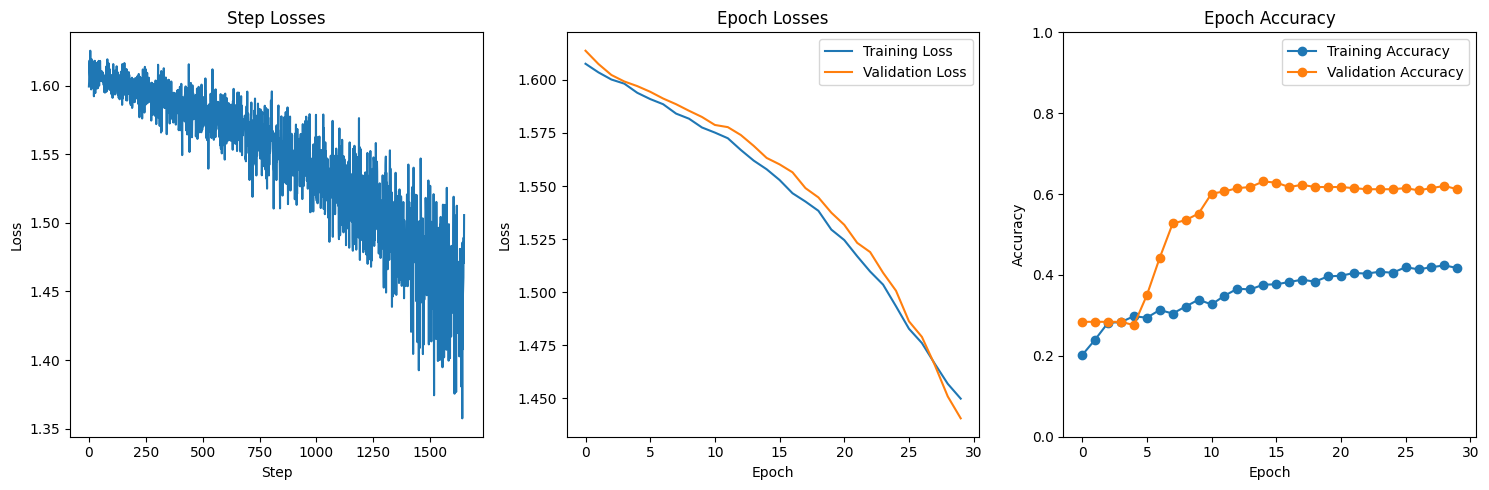

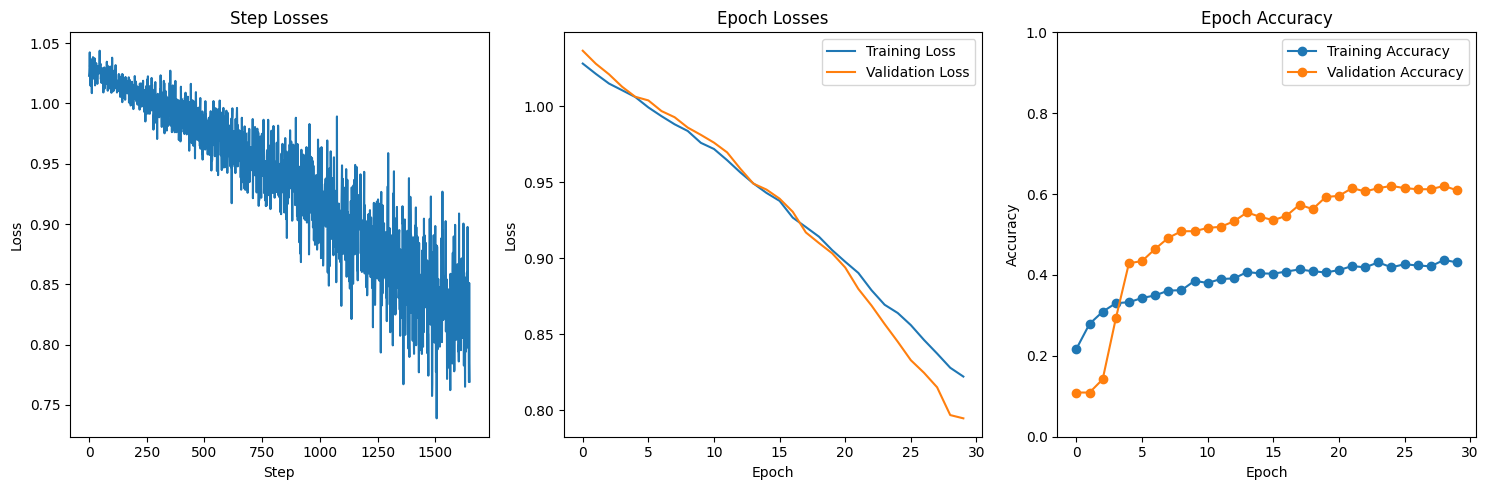

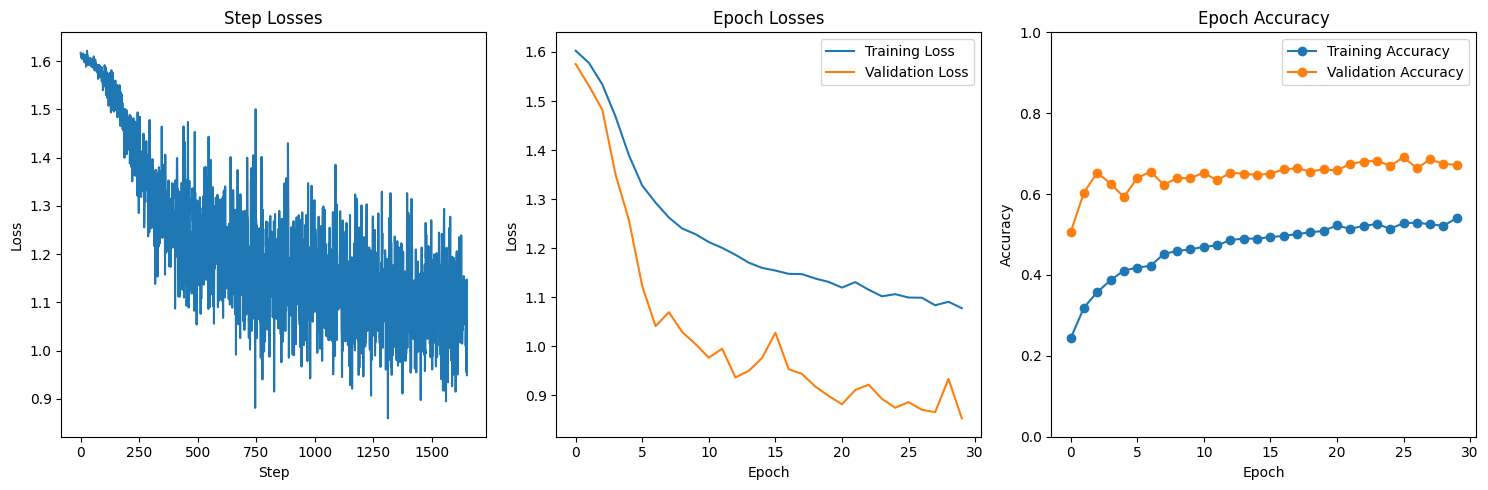

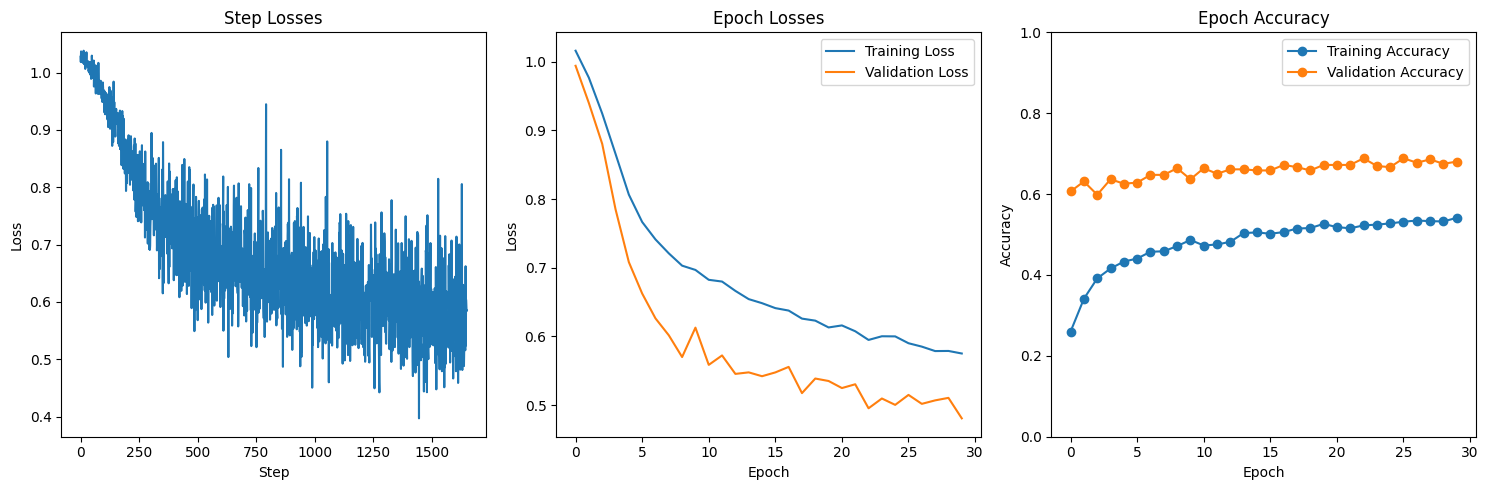

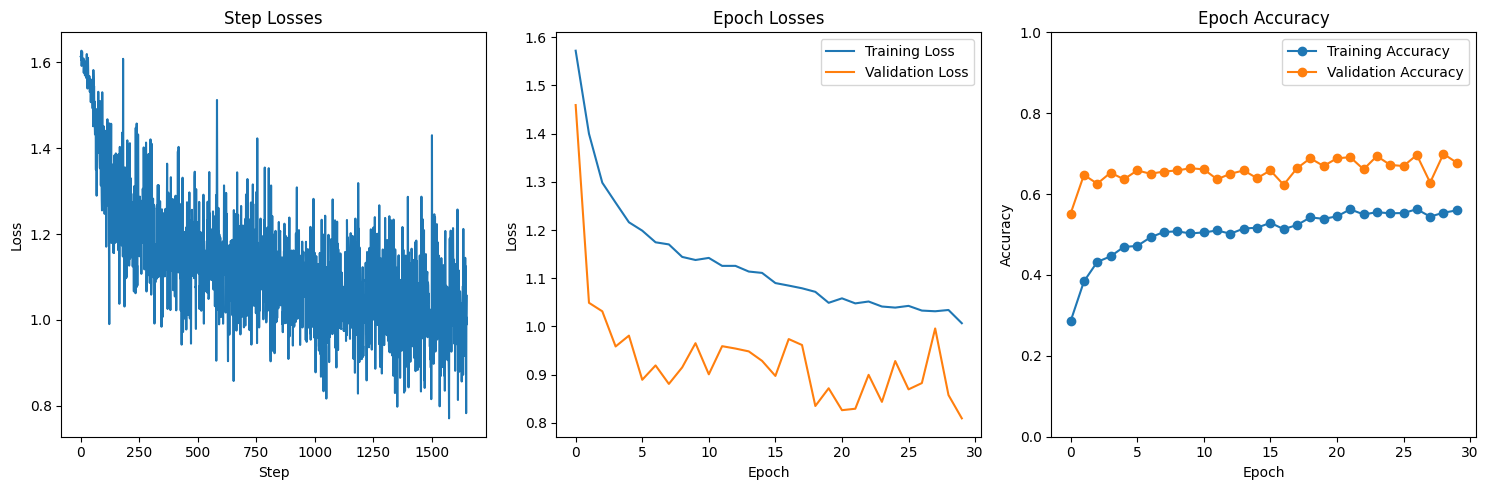

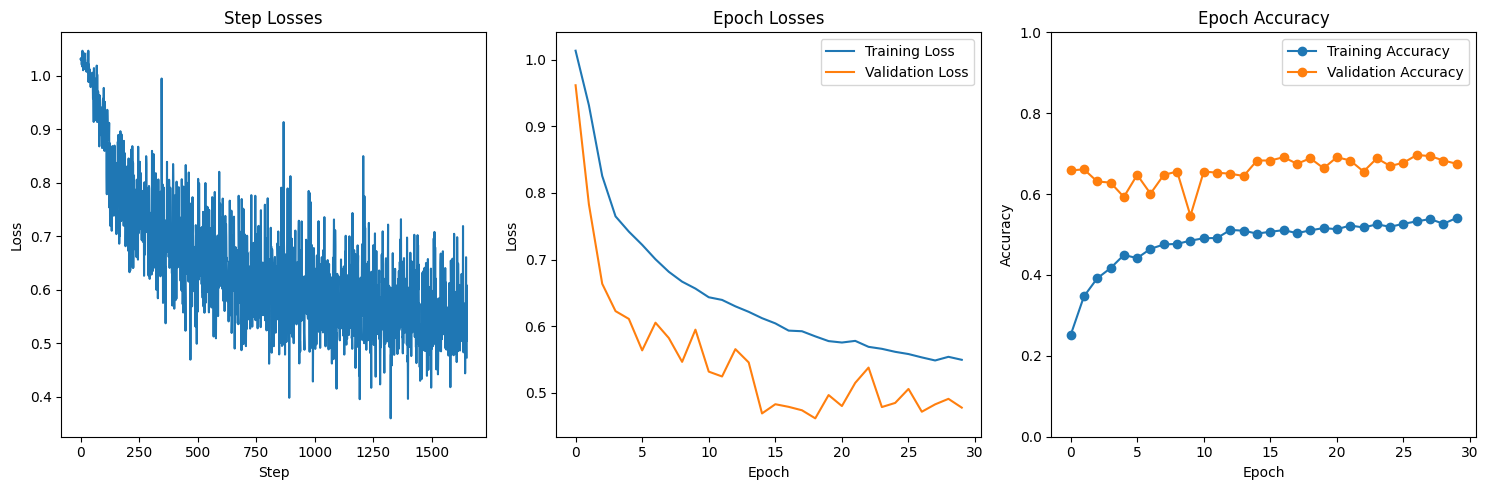

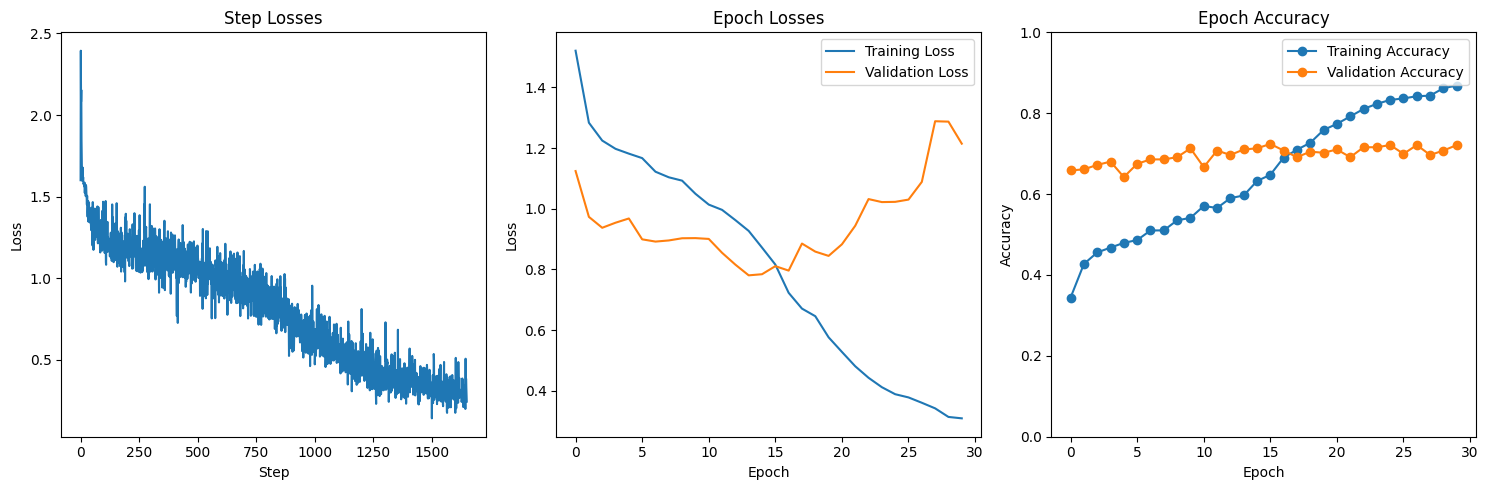

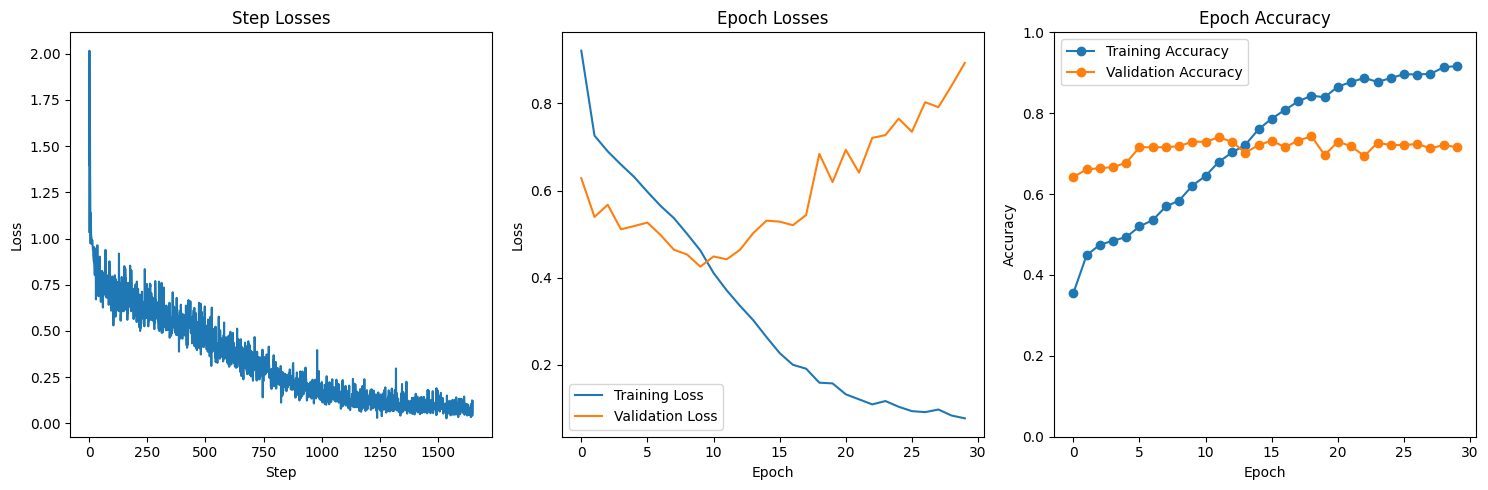

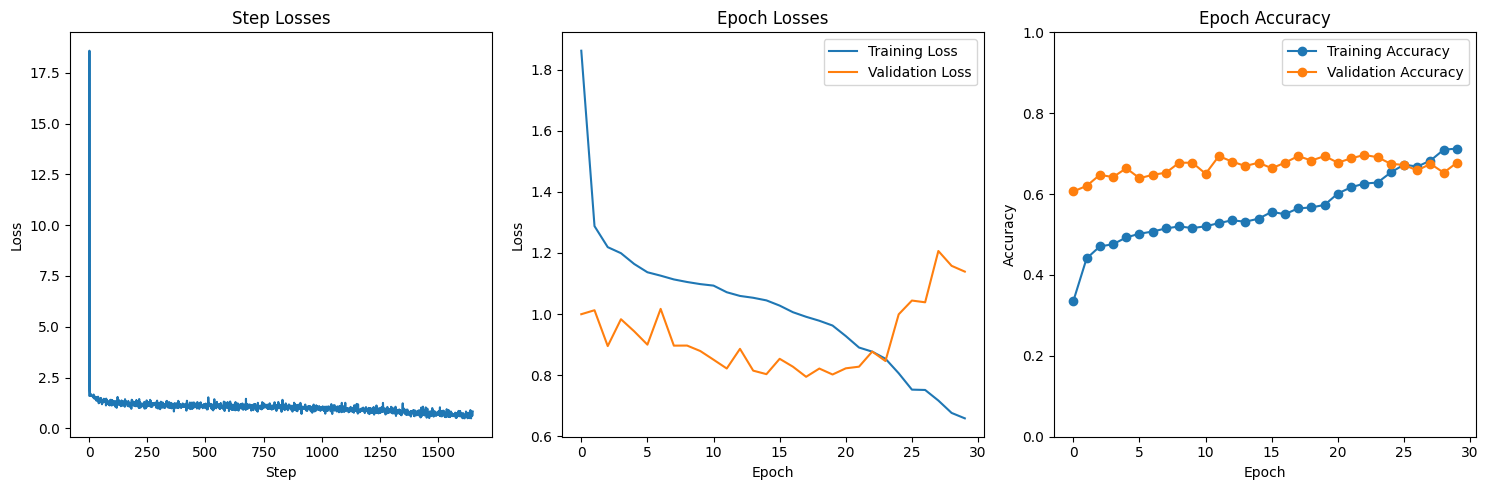

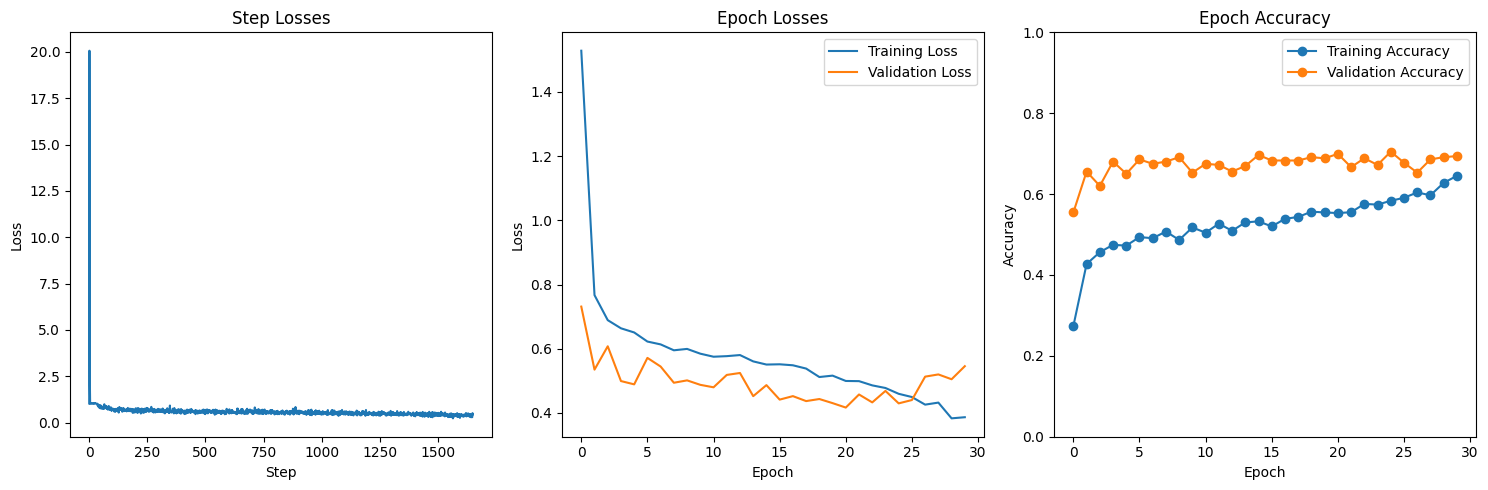

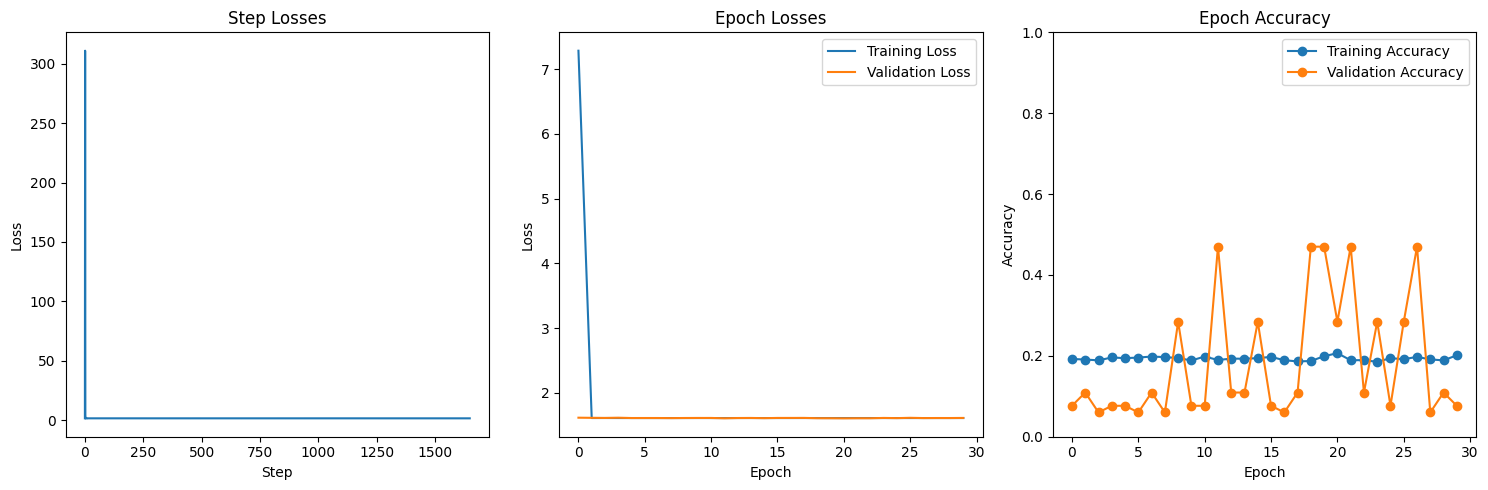

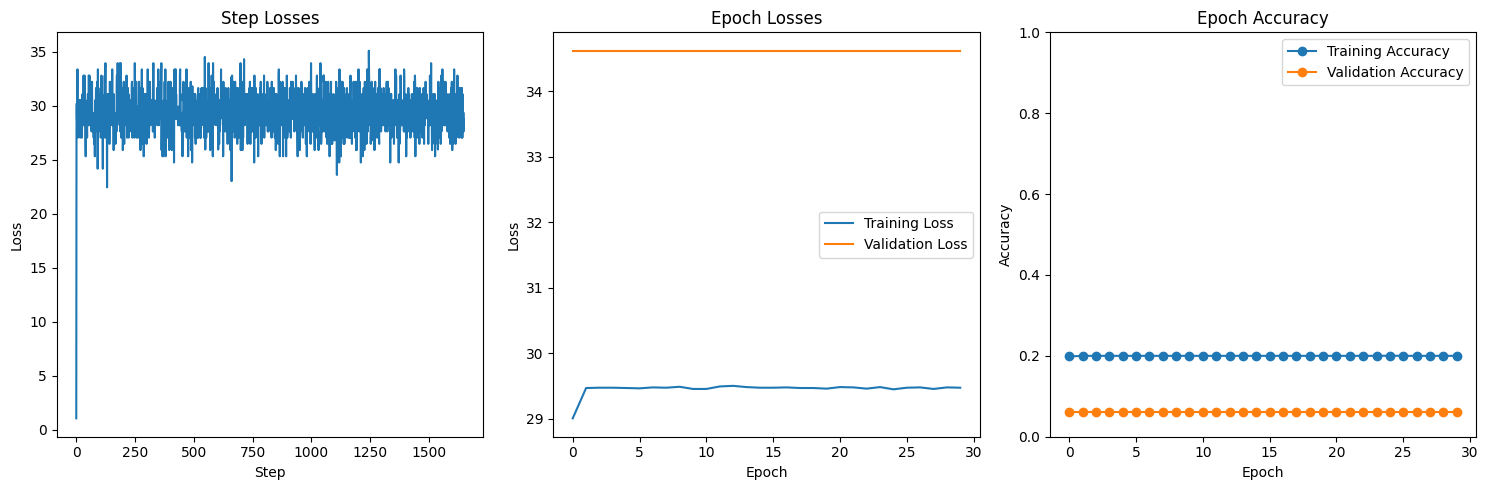

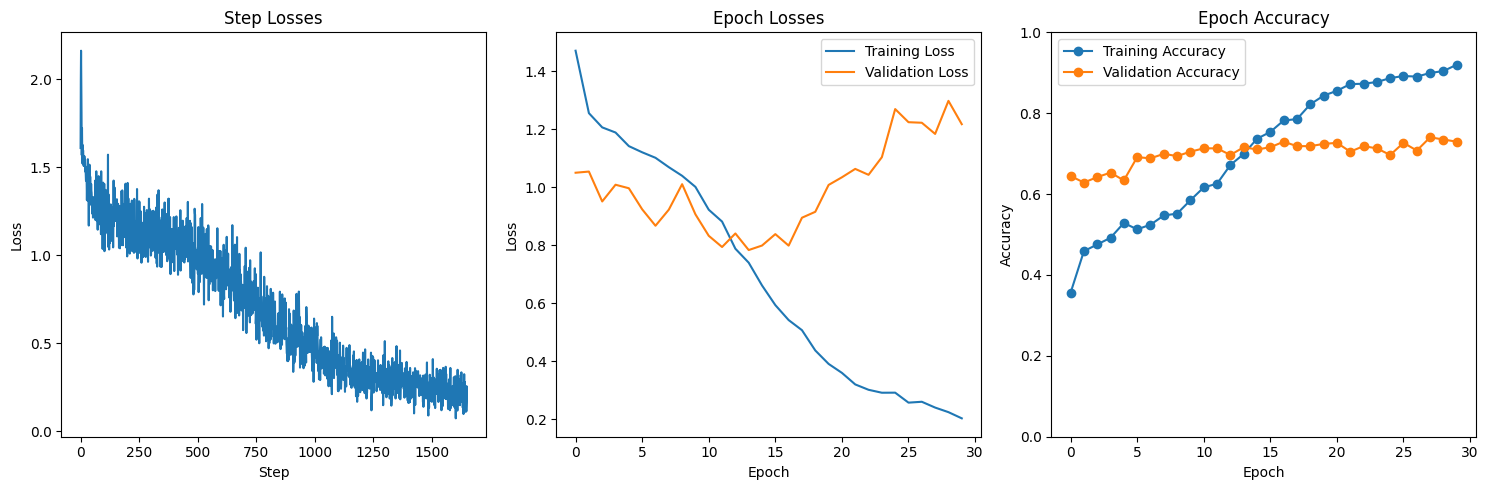

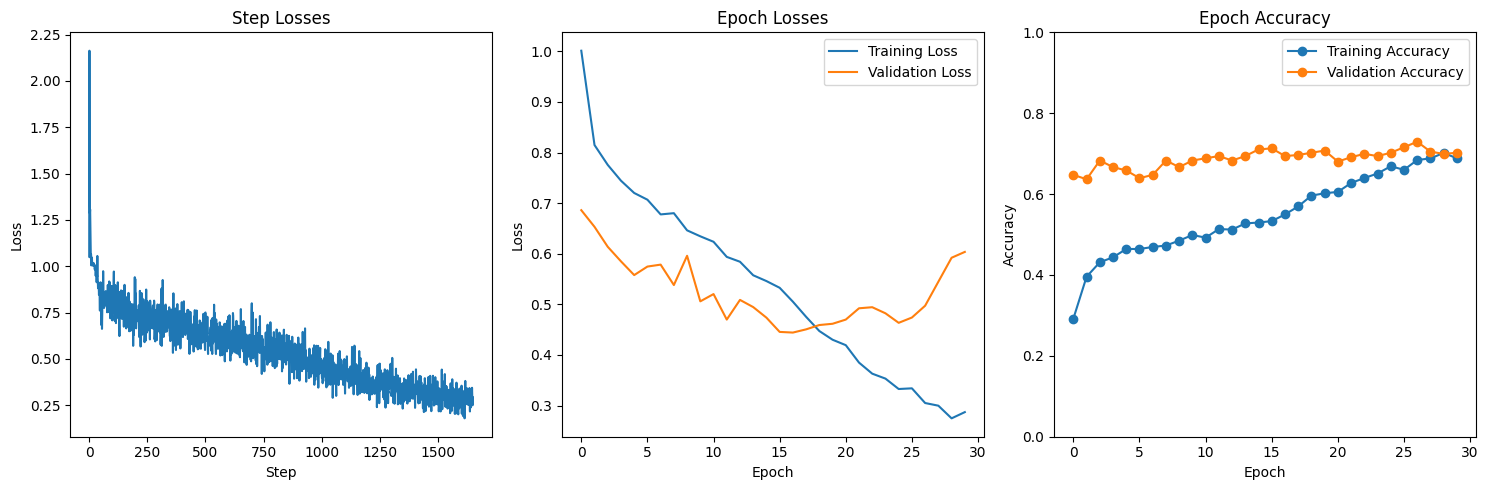

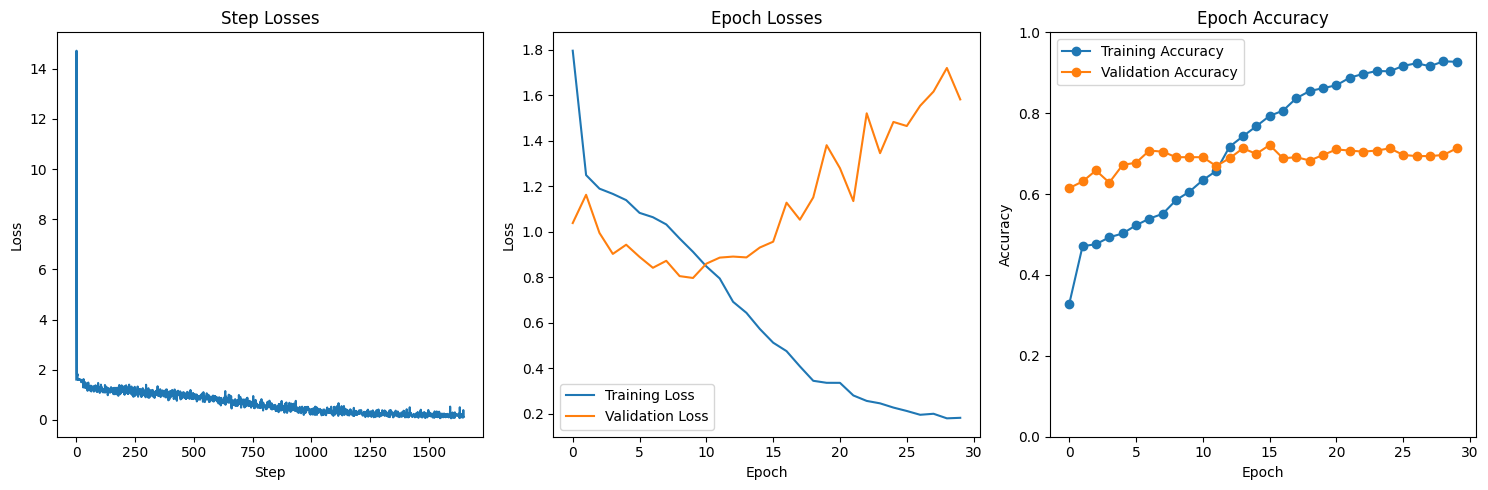

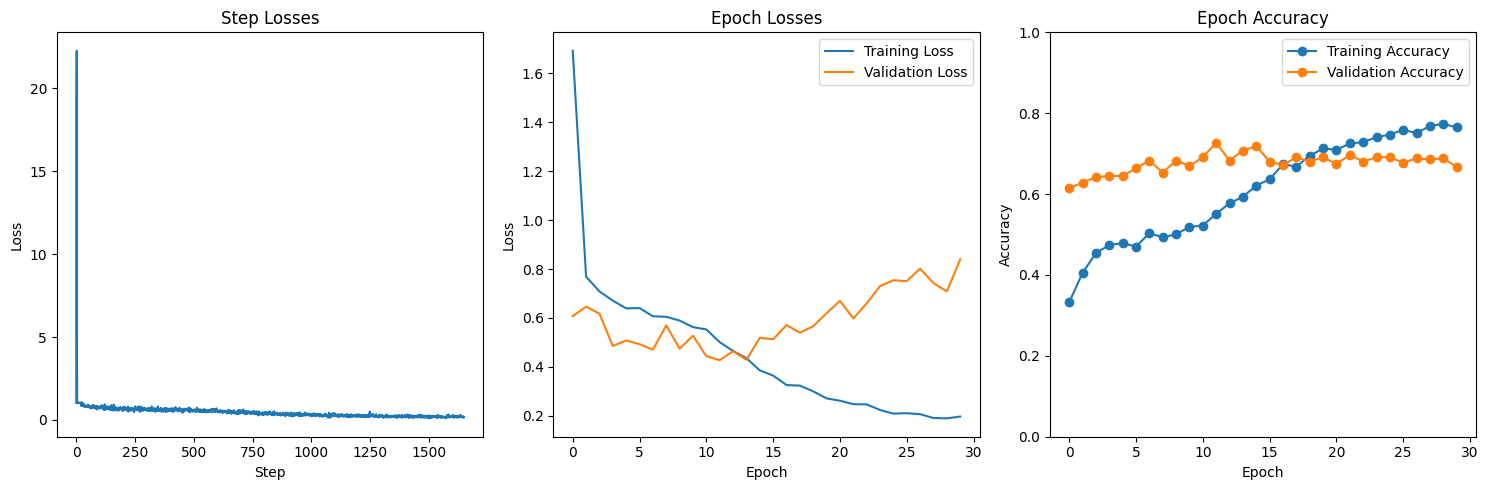

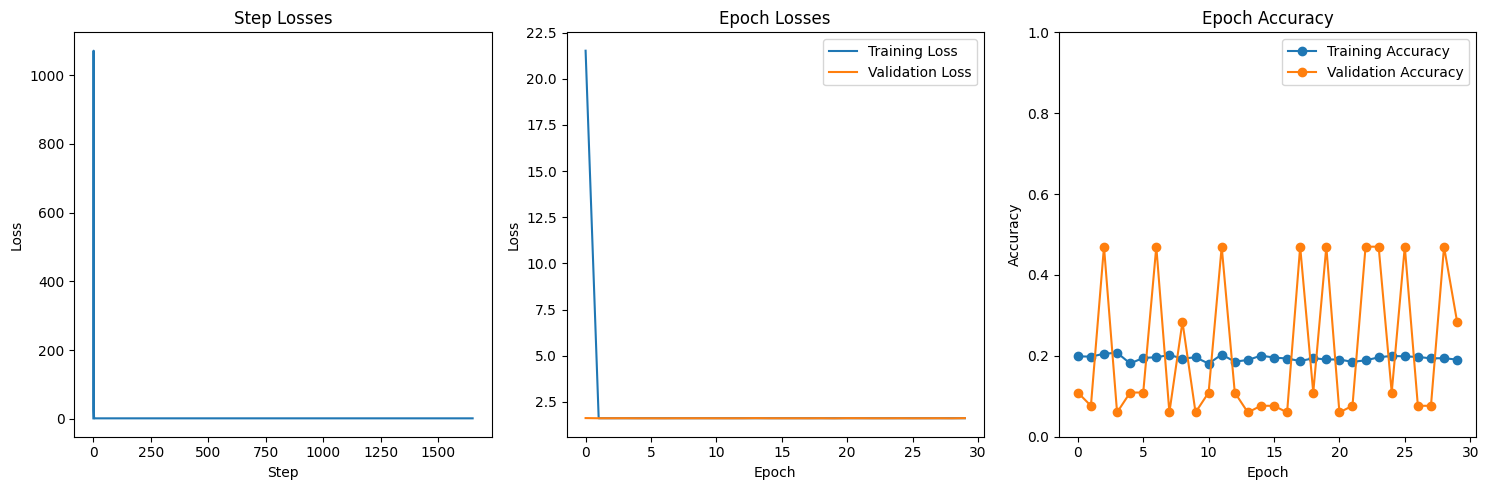

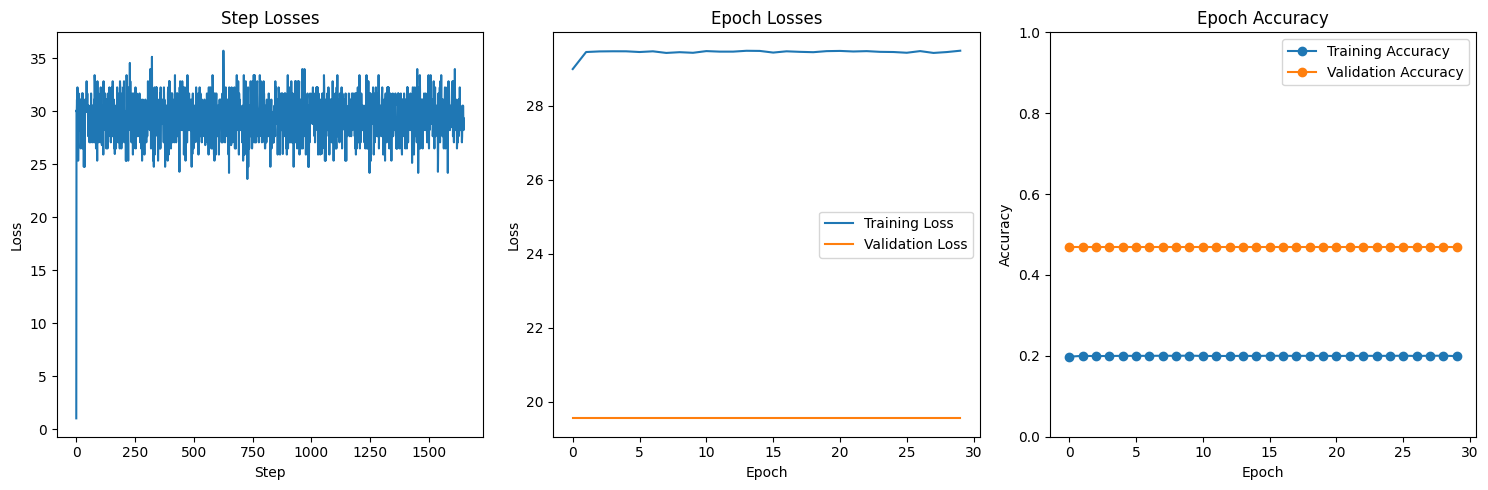

In [51]:
def model_fn():
    return Simone()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="Simone",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

# Simone2's Model

In [ ]:
class Simone2(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),   nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),   nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,3,padding=1),  nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.gap = nn.AdaptiveAvgPool2d(10)  # output: (B,128,1,1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128*28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 5)
        )
    def forward(self, x):
        x = self.body(x)
        x = self.gap(x)
        x = self.head(x)
        return x

In [79]:
model_simone2 = Simone2()
print(model_simone2)
summary(model_simone2, input_size=(batch_size, 3, img_size, img_size))

Simone2(
  (body): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=28)
  (head): Sequential(
    (0)

Layer (type:depth-idx)                   Output Shape              Param #
Simone2                                  [64, 5]                   --
├─Sequential: 1-1                        [64, 128, 56, 56]         --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        64
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Conv2d: 2-4                       [64, 32, 224, 224]        9,248
│    └─BatchNorm2d: 2-5                  [64, 32, 224, 224]        64
│    └─ReLU: 2-6                         [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-7                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-8                       [64, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-9                  [64, 64, 112, 112]        128
│    └─ReLU: 2-10                        [64, 64, 112, 112]        --
│    └─Conv2d: 2-11                      [64, 128, 112, 112]       73,856
│ 

In [ ]:
history, model_simone2 = train_model(
    model = model_simone2,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    num_epochs = 100,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_rsg")

# Try automatic grid search

Partono 1 esperimenti...

[1/1] Simone2_run_001_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/5


Epoch 1 training loss: 4.1076 train acc=0.2300, validation loss: 1.3611 validation acc=0.5437
Epoch 2/5


Epoch 2 training loss: 1.4788 train acc=0.2760, validation loss: 1.0875 validation acc=0.5656
Epoch 3/5


Epoch 3 training loss: 1.4177 train acc=0.3323, validation loss: 1.0613 validation acc=0.5820
Epoch 4/5


Epoch 4 training loss: 1.3886 train acc=0.3531, validation loss: 1.1723 validation acc=0.6148
Epoch 5/5


Epoch 5 training loss: 1.3910 train acc=0.3534, validation loss: 1.2628 validation acc=0.5137
Test Accuracy: 51.09% | Precision: 0.325 | Recall: 0.393 | F1: 0.327

Tutte le run sono salvate in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset//results/Simone2.csv


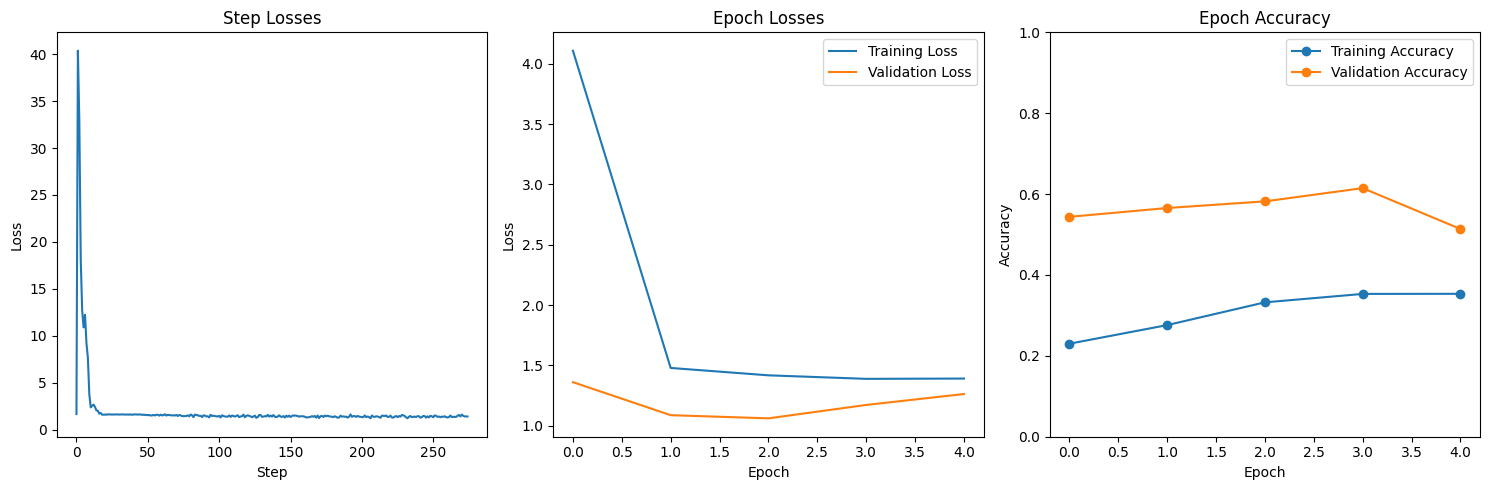

In [82]:
def model_fn():
    return Simone2()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="Simone2",
        csv_folder = base_path+"/results/",
        num_epochs=5,
        device=device
    )